In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import random
import math
from typing import Tuple

In [2]:
# Визуализация активности генов
def plot_gene_dynamics(df, title="Генетическая динамика", genes=None):
    """
    Визуализирует динамику экспрессии генов и энергии клетки, 
    масштабируя энергию так, чтобы её максимум был в 1/4 от максимума по генам.

    Аргументы:
    - df: DataFrame с результатами симуляции
    - title: заголовок графика
    - genes: словарь с ключами - названиями генов, и значениями - цветами линий
             Пример: {"ENGSENS": "blue", "HARVEST": "green"}
    """
    if genes is None:
        genes = {"ENGSENS": "blue", "FOODSENS": "red", "HARVEST": "green", "DIVISION": "purple"}

    # 1) Находим максимум по генам
    max_expr = 0.0
    for g in genes:
        if g in df.columns:
            max_expr = max(max_expr, df[g].max())

    if max_expr == 0:
        scale = 1.0
    else:
        # 2) Находим максимум энергии и считаем scale так,
        # чтобы max_energy*scale = max_expr/4
        max_energy = df["Energy"].max()
        scale = (max_expr / 4) / max_energy if max_energy != 0 else 1.0

    # 3) Создаём фигуру
    fig, ax = plt.subplots(figsize=(12, 6))

    # 4) Масштабированное поле энергии
    ax.fill_between(
        df["Tick"],
        df["Energy"] * scale,
        color="orange", alpha=0.2,
        label=f"Energy (scaled ×{scale:.2f})"
    )

    # 5) Линии активности генов
    for gene, color in genes.items():
        if gene in df.columns:
            ax.plot(df["Tick"], df[gene], label=gene, color=color, linewidth=2)

    # 6) Дополнительные базовые линии
    # ax.axhline(max_expr / 4, color='gray', linestyle=':', linewidth=0.5,
    #            label="Max energy on ¼ of max gene expr")
    ax.axhline(0, color='black', linestyle='--', linewidth=0.7)

    ax.set_title(title)
    ax.set_xlabel("Tick")
    ax.set_ylabel("Уровень (нормировано)")
    ax.legend(loc="upper left")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
# Работает

In [4]:
# Genes, protected from mutagenesis
EXCLUDED_FROM_MUTAGENESIS = {"MUTGUARD"}

# === Helper functions ===

def cond_all(conds, vars_):
    return all(eval(c, {}, vars_) for c in conds)

def cond_any(conds, vars_):
    return any(eval(c, {}, vars_) for c in conds)

def grow_and_cap(expr, promoter, enhancer):
    if promoter == 'wk':
        new = expr + 1
    elif promoter == 'av':
        new = expr * 2
    elif promoter == 'st':
        new = expr * 4
    else:
        new = expr
    cap = {'wk': 4, 'av': 16, 'st': 64}.get(enhancer, 64)
    return min(new, cap)

def gene_attempts(expr=12):  # Number of attempts a protein has to perform its function.
    return 3 + int(expr // 12)
    
# def toxin_effect(sigma, base_effect=0.4, k=0.01):
#     return (2 * base_effect) / (1 + np.exp(-k * sigma))
def toxin_effect(sigma, base_effect=0.4, k=0.01):
    return (base_effect * np.exp(sigma))

def detect_effect(sigma, detect_effect=0.05, k=1):
    return (k * np.exp(sigma)) / (64 * detect_effect)

def size_modifier(size_kDa: float ) -> float:  # Белок веса 150 кДа и более развалится в 4 раза быстрее, чем белок весом 10 кДа
    if size_kDa <= 10:
        return 1
    if size_kDa >= 150:
        return 0.25
    # линейная интерполяция: factor = 0.25 + (150 - size) / 140
    return 0.25 + (150 - size_kDa) / 140.0

# === State initialization ===

def initialize_state(receptors, metabolism, kinases, cell_cycle, division, initial_energy, initial_food):
    all_genes = {**receptors, **metabolism, **kinases, **cell_cycle, **division}
    gene_list = list(all_genes.keys())
    return {
        "all_genes": all_genes,
        "gene_list": gene_list,
        "gene_expr": {g: 1 for g in gene_list},
        "gene_status": {g: "inactive" for g in gene_list},
        "gene_prot": {g: 0.0 for g in gene_list},
        "deact_delay": {g: False for g in gene_list},
        "energy": initial_energy,
        "food": initial_food,
        "toxin_detected": False,
        "expressed_flag": {g: False for g in gene_list},
        "mut_detected": False,
        "genes": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
        "reference_genome": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
    }

# === Toxin logic ===

def evaluate_toxins(toxins: dict, toxin_k: float):
    """
    Computes the effects of toxins.
    Returns: tox_penalties, tox_levels
    """
    tox_penalties = {}
    tox_levels = {}
    for name, (sigma, (param, base_eff)) in toxins.items():
        tox_levels[name] = sigma
        eff = toxin_effect(sigma, base_eff, toxin_k)
        if param == "common":
            for p in ["energy", "TPM"]:
                tox_penalties[p] = tox_penalties.get(p, 0.0) + eff
        else:
            tox_penalties[param] = tox_penalties.get(param, 0.0) + eff
    return tox_penalties, tox_levels

# === Logic of cellular products (including toxic ones) ===

def generate_cellular_products(
    prev_expr: dict,
    prev_status: dict,
    cellular_products: dict,
    env_products: dict,
    toxins: dict,
    energy_spent: float,
    TPM_sum: float
) -> Tuple[dict, dict]:
    """
    Step 2. Generate cellular products and increase sigma of toxins.
    Returns updated (env_products, toxins).
    """
    for name, (mode, coeff) in cellular_products.items():
        if mode == "energy":
            delta = coeff * energy_spent
        elif mode == "TPMsum":
            delta = coeff * TPM_sum
        elif mode in prev_status:
            # ген-специфичный продукт
            delta = coeff * prev_expr[mode] if prev_status[mode] == "active" else 0.0
        else:
            raise ValueError(f"Unknown production mode '{mode}' for product '{name}'")

        env_products[name] = env_products.get(name, -3.0) + delta

        if name in toxins:
            sigma, (p, b) = toxins[name]
            toxins[name] = (sigma + delta, (p, b))

    return env_products, toxins

# === Gene logic ===

def process_gene_functions(
    all_genes: dict,
    gene_list: list,
    prev_status: dict,
    prev_expr: dict,
    new_expr: dict,
    gene_prot: dict,
    energy: float,
    toxins: dict,
    state: dict
) -> Tuple[bool, float, float, dict]:
    division_happened = False
    division_cost = 0.0

    for g, record in all_genes.items():
        thr, mode, prom, enh, size_kDa, on_cond, off_cond, func = record
        
        if not func:
            continue

        ftype, val = func

        # 1) Проверяем, накопился ли белок до порога thr
        if gene_prot[g] < thr:  # Если нет, функция не выполняется вообще
            continue

        # 2) Если накопленного протеина достаточно, запускаем функцию.
        #    Все функции теперь получают "eff = gene_prot[g]".
        eff_prot = gene_prot[g]
        
        if ftype == "energy":
            energy += eff_prot * val

        elif ftype == "process":
            to_proc, rem = eff_prot, 0.0
            for tgt in gene_list:
                if tgt == g or gene_prot[tgt] <= 0 or to_proc <= 0:
                    continue
                cut = min(gene_prot[tgt], to_proc)
                gene_prot[tgt] -= cut
                to_proc     -= cut
                rem         += cut
            energy += rem * val

        elif ftype == "RNAdigest":
            to_dig, dig = eff_prot, 0.0
            for tgt in gene_list:
                if to_dig <= 0:
                    break
                av = new_expr[tgt] - 1
                if av <= 0:
                    continue
                cut = min(av, to_dig)
                new_expr[tgt] -= cut
                to_dig       -= cut
                dig          += cut
            energy += dig * val

        elif ftype == "div":
            division_cost    += val
            division_happened = True

        elif ftype == "detox":
            detox_power = (eff_prot / 64) * val
            for name in toxins:
                sigma, (param, base_eff) = toxins[name]
                new_sigma = max(-3, sigma - detox_power)
                toxins[name] = (new_sigma, (param, base_eff))

        # --- mutation sensor ---
        elif ftype == "mutsens":
            sens_chance = val
            attempts = gene_attempts(eff_prot)
            ref  = state["reference_genome"]
            curr = state["genes"]

            found = False
            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene] and random.random() < sens_chance:
                        found = True
                        break
                if found:
                    break
            if found:
                state["mut_detected"] = True

        # --- mutation repair ---
        elif ftype == "mutrep" and state.get("mut_detected", False):
            rep_chance = val
            attempts = gene_attempts(eff_prot)
            ref  = state["reference_genome"]  # “normal” genome prior to the last division
            curr = state["genes"]             # “physical” copy currently affected by mutations

            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene]:  # found a gene where current != reference
                        if random.random() < rep_chance:
                            curr[gene] = ref[gene]
                        elif random.random() < rep_chance:
                            curr[gene] = mutate_gene(curr[gene])
            # print(f"[MUTREP] gene={g}, attempts={attempts}, ref!=curr for genes:",  # Logging repairation
            #     [x for x in ref if curr[x]!=ref[x]])                                # Logging repairation

    return division_happened, division_cost, energy, toxins

# === Mutagenesis logic ===

def mutate_genes(all_genes: dict, mutation_chance: float) -> dict:
    """
    Randomly mutates some genes,
    but skips those listed in EXCLUDED_FROM_MUTAGENESIS.
    """
    new_genes = copy.deepcopy(all_genes)
    promoters = ['wk', 'av', 'st']
    enhancers = ['wk', 'av', 'st']
    
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in new_genes.items():
        # skip if this gene is in the exclusion list
        if g in EXCLUDED_FROM_MUTAGENESIS:
            continue

        if random.random() < mutation_chance:
            mutation_type = random.choice(['threshold', 'promoter', 'enhancer'])

            if mutation_type == 'threshold':
                delta = random.choice([-1, 1])
                thr = max(1, thr + delta)

            elif mutation_type == 'promoter':
                prom = random.choice(promoters)

            elif mutation_type == 'enhancer':
                enh = random.choice(enhancers)

            new_genes[g] = (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func)

    return new_genes

def mutate_gene(gene_record):
    thr, mode, prom, enh, size_kDa, on_cond, off_cond, func = gene_record
    promoters = ['wk', 'av', 'st']
    enhancers = ['wk', 'av', 'st']
    mutation_type = random.choice(['threshold','promoter','enhancer'])
    if mutation_type == 'threshold':
        thr = max(1, thr + random.choice([-1,1]))
    elif mutation_type == 'promoter':
        prom = random.choice(promoters)
    else:
        enh = random.choice(enhancers)
    return (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func)

# === One simulation step ===

def simulate_tick(state, toxins, energy_cost, toxin_k, cellular_products, env_products, protein_stability):
    
    # 1. Unpack state
    all_genes      = state["all_genes"]
    gene_list      = state["gene_list"]
    prev_expr      = state["gene_expr"]
    prev_status    = state["gene_status"]
    prev_prot      = state["gene_prot"]
    deact_delay    = state["deact_delay"]
    energy         = state["energy"]
    food           = state["food"]
    prev_expressed = state["expressed_flag"]

    # 2. TPM costs
    TPM_sum = sum(prev_expr.values())
    tpm_cost = TPM_sum * energy_cost
    energy_spent = tpm_cost

    # 3. Products and toxins
    env_products, toxins = generate_cellular_products(
        prev_expr, prev_status,
        cellular_products, env_products,
        toxins,
        energy_spent, TPM_sum
    )
    tox_penalties, tox_levels = evaluate_toxins(toxins, toxin_k)
    total_toxins = max(tox_levels.values())

    # 4. Toxin detection
    toxin_detected = False
    for g, (_, _, _, _, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if func and func[0] == "toxsens" and prev_status[g] == "active":
            sens_prob = detect_effect(total_toxins, detect_effect=func[1], k=prev_expr[g])
            if sens_prob > 1:
                toxin_detected = True
                break

    # 5. Toxicity penalty
    if "energy" in tox_penalties:
        energy -= tox_penalties["energy"]

    # 6. Local variables
    local = {
        "Energy": energy,
        "Food": food,
        "Toxin": total_toxins,
        "Toxin_detected": toxin_detected
    }
    local.update(prev_status)

    # 7. Flags
    new_expressed = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        stop_cond  = cond_any(off_cond, local)
        start_cond = cond_all(on_cond, local) and not stop_cond
        new_expressed[g] = (prev_expressed[g] and not stop_cond) or start_cond
    had_off = {g: cond_any(all_genes[g][6], local) for g in gene_list}
    
    # 8. Expression
    new_expr = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if new_expressed[g]:
            val  = grow_and_cap(prev_expr[g], prom, enh)
            tpen = 1 - min(tox_penalties.get("TPM", 0.0), 1)
            new_expr[g] = max(1, val * tpen)
        else:
            new_expr[g] = 1

    # 9. Status
    new_status = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if deact_delay[g]:
            new_status[g] = "inactive"
            deact_delay[g] = False
        elif prev_status[g] == "active":
            if had_off[g]:
                new_status[g] = "active"
                deact_delay[g] = True
            else:
                new_status[g] = "active"
        else:
            new_status[g] = (
                "active"
                if (not had_off[g] and cond_all(on_cond, local) and new_expr[g] >= thr)
                else "inactive"
            )

    # 11. Protein dynamics
    gene_prot = {}
    for g in gene_list:
        base_stab = protein_stability.get(g, 1.0)
        # читаем вес из all_genes[g][4]:
        size_kDa = state["all_genes"][g][4]
        stab = base_stab * size_modifier(size_kDa)

        decayed = prev_prot[g] * stab
        added = max(0, prev_expr[g] - 1)
        gene_prot[g] = decayed + added

    # 12. Выполнение функций (теперь на основе накопленного gene_prot):
    division_happened, division_cost, energy, toxins = process_gene_functions(
        all_genes, gene_list, prev_status,
        prev_expr, new_expr, gene_prot,
        energy, toxins,
        state
    )

    # 13. Division reset
    if division_happened:
         # optional: run repair again to fix any mutations that would otherwise be inherited
        state["reference_genome"] = copy.deepcopy(state["genes"])
        state["mut_detected"] = False
        for g in gene_list:
            new_expr[g]   = 1
            new_status[g] = "inactive"
            gene_prot[g]  = 0.0
            deact_delay[g]= False
        toxin_detected = False

    # 14. Final energy deduction
    energy -= sum(new_expr.values()) * energy_cost
    energy -= division_cost

    # 15. Logging and return
    record = {"Food": round(food, 2)}
    record.update({n: round(v, 3) for n, v in env_products.items()})
    record.update({n: round(tox_levels[n], 3) for n in tox_levels})
    record["Energy"] = round(energy, 2)
    record["mut_detected"] = state['mut_detected']
    record["tox_detected"] = state['toxin_detected']
    record.update(new_expr)

    next_state = {
        "all_genes":      all_genes,
        "gene_list":      gene_list,
        "gene_expr":      new_expr,
        "gene_status":    new_status,
        "gene_prot":      gene_prot,
        "deact_delay":    deact_delay,
        "energy":         energy,
        "food":           food,
        "toxin_detected": toxin_detected,
        "expressed_flag": new_expressed,
        "mut_detected":   state["mut_detected"],
        "genes":          state["genes"],
        "reference_genome": state["reference_genome"],
    }
    stop = energy <= -3
    return next_state, record, stop, env_products, toxins

# === Main function ===

def run_simulation(
    ticks: int = 50,
    initial_food: float = 1.0,
    initial_energy: float = 1.0,
    energy_cost: float = 0.01,
    receptors: dict = {},
    metabolism: dict = {},
    kinases: dict = {},
    cell_cycle: dict = {},
    division: dict = {},
    toxins: dict = None,
    toxin_k: float = 1,
    cellular_products: dict = None,
    mutation_chance: float = 0.0,
    protein_stability=None,
) -> Tuple[pd.DataFrame, dict]:

    # Initialization
    state = initialize_state(
        receptors, metabolism, kinases, cell_cycle, division,
        initial_energy, initial_food
    )
    records = []
    toxins = toxins or {}
    cellular_products = cellular_products or {}
    if isinstance(protein_stability, (int, float)):
        protein_stability = {g: protein_stability for g in state["gene_list"]}
    elif protein_stability is None:
        protein_stability = {g: 1.0 for g in state["gene_list"]}


    # env_products — environment level (sigma) for each cellular product
    env_products = {name: -3.0 for name in cellular_products.keys()}

    # Main loop
    for tick in range(ticks):
        if mutation_chance > 0:
            state["genes"] = mutate_genes(state["genes"], mutation_chance)
        state["all_genes"] = state["genes"]
        state, record, stop, env_products, toxins = simulate_tick(
            state=state,
            toxins=toxins,
            energy_cost=energy_cost,
            toxin_k=toxin_k,
            cellular_products=cellular_products,
            env_products=env_products,
            protein_stability=protein_stability
        )
        record["Tick"] = tick
        records.append(record)
        if stop:
            print(f"Cell died at tick {tick}, energy={state['energy']:.2f}")
            break

    return pd.DataFrame(records), state["all_genes"]

In [5]:
# Добавляем счётчик клеток

In [6]:
# Genes, protected from mutagenesis
EXCLUDED_FROM_MUTAGENESIS = {"MUTGUARD"}

# === Helper functions ===

def cond_all(conds, vars_):
    return all(eval(c, {}, vars_) for c in conds)

def cond_any(conds, vars_):
    return any(eval(c, {}, vars_) for c in conds)

def grow_and_cap(expr, promoter, enhancer):
    if promoter == 'wk':
        new = expr + 1
    elif promoter == 'av':
        new = expr * 2
    elif promoter == 'st':
        new = expr * 4
    else:
        new = expr
    cap = {'wk': 4, 'av': 16, 'st': 64}.get(enhancer, 64)
    return min(new, cap)

def gene_attempts(expr=12):  # Number of attempts a protein has to perform its function.
    return 3 + int(expr // 12)
    
# def toxin_effect(sigma, base_effect=0.4, k=0.01):
#     return (2 * base_effect) / (1 + np.exp(-k * sigma))
def toxin_effect(sigma, base_effect=0.4, k=0.01):
    return (base_effect * np.exp(sigma))

def detect_effect(sigma, detect_effect=0.05, k=1):
    return (k * np.exp(sigma)) / (64 * detect_effect)

def size_modifier(size_kDa: float ) -> float:  # Белок веса 150 кДа и более развалится в 4 раза быстрее, чем белок весом 10 кДа
    if size_kDa <= 10:
        return 1
    if size_kDa >= 150:
        return 0.25
    # линейная интерполяция: factor = 0.25 + (150 - size) / 140
    return 0.25 + (150 - size_kDa) / 140.0

# === State initialization ===

def initialize_state(receptors, metabolism, kinases, cell_cycle, division, initial_energy, initial_food):
    all_genes = {**receptors, **metabolism, **kinases, **cell_cycle, **division}
    gene_list = list(all_genes.keys())
    return {
        "all_genes": all_genes,
        "gene_list": gene_list,
        "gene_expr": {g: 1 for g in gene_list},
        "gene_status": {g: "inactive" for g in gene_list},
        "gene_prot": {g: 0.0 for g in gene_list},
        "deact_delay": {g: False for g in gene_list},
        "energy": initial_energy,
        "food": initial_food,
        "toxin_detected": False,
        "expressed_flag": {g: False for g in gene_list},
        "mut_detected": False,
        "genes": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
        "reference_genome": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
    }

# === Toxin logic ===

def evaluate_toxins(toxins: dict, toxin_k: float):
    """
    Computes the effects of toxins.
    Returns: tox_penalties, tox_levels
    """
    tox_penalties = {}
    tox_levels = {}
    for name, (sigma, (param, base_eff)) in toxins.items():
        tox_levels[name] = sigma
        eff = toxin_effect(sigma, base_eff, toxin_k)
        if param == "common":
            for p in ["energy", "TPM"]:
                tox_penalties[p] = tox_penalties.get(p, 0.0) + eff
        else:
            tox_penalties[param] = tox_penalties.get(param, 0.0) + eff
    return tox_penalties, tox_levels

# === Logic of cellular products (including toxic ones) ===

def generate_cellular_products(
    prev_expr: dict,
    prev_status: dict,
    cellular_products: dict,
    env_products: dict,
    toxins: dict,
    energy_spent: float,
    TPM_sum: float
) -> Tuple[dict, dict]:
    """
    Step 2. Generate cellular products and increase sigma of toxins.
    Returns updated (env_products, toxins).
    """
    for name, (mode, coeff) in cellular_products.items():
        if mode == "energy":
            delta = coeff * energy_spent
        elif mode == "TPMsum":
            delta = coeff * TPM_sum
        elif mode in prev_status:
            # ген-специфичный продукт
            delta = coeff * prev_expr[mode] if prev_status[mode] == "active" else 0.0
        else:
            raise ValueError(f"Unknown production mode '{mode}' for product '{name}'")

        env_products[name] = env_products.get(name, -3.0) + delta

        if name in toxins:
            sigma, (p, b) = toxins[name]
            toxins[name] = (sigma + delta, (p, b))

    return env_products, toxins

# === Gene logic ===

def process_gene_functions(
    all_genes: dict,
    gene_list: list,
    prev_status: dict,
    prev_expr: dict,
    new_expr: dict,
    gene_prot: dict,
    energy: float,
    toxins: dict,
    state: dict
) -> Tuple[bool, float, float, dict]:
    division_happened = False
    division_cost = 0.0

    for g, record in all_genes.items():
        thr, mode, prom, enh, size_kDa, on_cond, off_cond, func = record
        
        if not func:
            continue

        ftype, val = func

        # 1) Проверяем, накопился ли белок до порога thr
        if gene_prot[g] < thr:  # Если нет, функция не выполняется вообще
            continue

        # 2) Если накопленного протеина достаточно, запускаем функцию.
        #    Все функции теперь получают "eff = gene_prot[g]".
        eff_prot = gene_prot[g]
        
        if ftype == "energy":
            energy += eff_prot * val

        elif ftype == "process":
            to_proc, rem = eff_prot, 0.0
            for tgt in gene_list:
                if tgt == g or gene_prot[tgt] <= 0 or to_proc <= 0:
                    continue
                cut = min(gene_prot[tgt], to_proc)
                gene_prot[tgt] -= cut
                to_proc     -= cut
                rem         += cut
            energy += rem * val

        elif ftype == "RNAdigest":
            to_dig, dig = eff_prot, 0.0
            for tgt in gene_list:
                if to_dig <= 0:
                    break
                av = new_expr[tgt] - 1
                if av <= 0:
                    continue
                cut = min(av, to_dig)
                new_expr[tgt] -= cut
                to_dig       -= cut
                dig          += cut
            energy += dig * val

        elif ftype == "div":
            division_cost    += val
            division_happened = True

        elif ftype == "detox":
            detox_power = (eff_prot / 64) * val
            for name in toxins:
                sigma, (param, base_eff) = toxins[name]
                new_sigma = max(-3, sigma - detox_power)
                toxins[name] = (new_sigma, (param, base_eff))

        # --- mutation sensor ---
        elif ftype == "mutsens":
            sens_chance = val
            attempts = gene_attempts(eff_prot)
            ref  = state["reference_genome"]
            curr = state["genes"]

            found = False
            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene] and random.random() < sens_chance:
                        found = True
                        break
                if found:
                    break
            if found:
                state["mut_detected"] = True

        # --- mutation repair ---
        elif ftype == "mutrep" and state.get("mut_detected", False):
            rep_chance = val
            attempts = gene_attempts(eff_prot)
            ref  = state["reference_genome"]  # “normal” genome prior to the last division
            curr = state["genes"]             # “physical” copy currently affected by mutations

            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene]:  # found a gene where current != reference
                        if random.random() < rep_chance:
                            curr[gene] = ref[gene]
                        elif random.random() < rep_chance:
                            curr[gene] = mutate_gene(curr[gene])
            # print(f"[MUTREP] gene={g}, attempts={attempts}, ref!=curr for genes:",  # Logging repairation
            #     [x for x in ref if curr[x]!=ref[x]])                                # Logging repairation

    return division_happened, division_cost, energy, toxins

# === Mutagenesis logic ===

def mutate_genes(all_genes: dict, mutation_chance: float) -> dict:
    """
    Randomly mutates some genes,
    but skips those listed in EXCLUDED_FROM_MUTAGENESIS.
    """
    new_genes = copy.deepcopy(all_genes)
    promoters = ['wk', 'av', 'st']
    enhancers = ['wk', 'av', 'st']
    
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in new_genes.items():
        # skip if this gene is in the exclusion list
        if g in EXCLUDED_FROM_MUTAGENESIS:
            continue

        if random.random() < mutation_chance:
            mutation_type = random.choice(['threshold', 'promoter', 'enhancer'])

            if mutation_type == 'threshold':
                delta = random.choice([-1, 1])
                thr = max(1, thr + delta)

            elif mutation_type == 'promoter':
                prom = random.choice(promoters)

            elif mutation_type == 'enhancer':
                enh = random.choice(enhancers)

            new_genes[g] = (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func)

    return new_genes

def mutate_gene(gene_record):
    thr, mode, prom, enh, size_kDa, on_cond, off_cond, func = gene_record
    promoters = ['wk', 'av', 'st']
    enhancers = ['wk', 'av', 'st']
    mutation_type = random.choice(['threshold','promoter','enhancer'])
    if mutation_type == 'threshold':
        thr = max(1, thr + random.choice([-1,1]))
    elif mutation_type == 'promoter':
        prom = random.choice(promoters)
    else:
        enh = random.choice(enhancers)
    return (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func)

# === One simulation step ===

def simulate_tick(state, toxins, energy_cost, toxin_k, cellular_products, env_products, protein_stability):
    
    # 1. Unpack state
    all_genes      = state["all_genes"]
    gene_list      = state["gene_list"]
    prev_expr      = state["gene_expr"]
    prev_status    = state["gene_status"]
    prev_prot      = state["gene_prot"]
    deact_delay    = state["deact_delay"]
    energy         = state["energy"]
    food           = state["food"]
    prev_expressed = state["expressed_flag"]
    cell_count      = state["cell_count"]
    support_level   = state["support_cell_num"]
    support_ratio   = cell_count / support_level

    # 2. TPM costs
    TPM_sum = sum(prev_expr.values())
    tpm_cost = TPM_sum * energy_cost
    energy_spent = tpm_cost

    # 3. Products and toxins
    env_products, toxins = generate_cellular_products(
        prev_expr, prev_status,
        cellular_products, env_products,
        toxins,
        energy_spent, TPM_sum
    )
    for name in env_products:
        env_products[name] *= cell_count
    tox_penalties, tox_levels = evaluate_toxins(toxins, toxin_k)
    total_toxins = max(tox_levels.values())

    # 4. Toxin detection
    toxin_detected = False
    for g, (_, _, _, _, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if func and func[0] == "toxsens" and prev_status[g] == "active":
            sens_prob = detect_effect(total_toxins, detect_effect=func[1], k=prev_expr[g])
            if sens_prob > 1:
                toxin_detected = True
                break

    # 5. Toxicity penalty
    if "energy" in tox_penalties:
        energy -= tox_penalties["energy"]

    # 6. Local variables
    local = {
        "Energy": energy,
        "Food": food,
        "Toxin": total_toxins,
        "Toxin_detected": toxin_detected
    }
    local.update(prev_status)

    # 7. Flags
    new_expressed = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        stop_cond  = cond_any(off_cond, local)
        start_cond = cond_all(on_cond, local) and not stop_cond
        new_expressed[g] = (prev_expressed[g] and not stop_cond) or start_cond
    had_off = {g: cond_any(all_genes[g][6], local) for g in gene_list}
    
    # 8. Expression
    new_expr = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if new_expressed[g]:
            val  = grow_and_cap(prev_expr[g], prom, enh)
            tpen = 1 - min(tox_penalties.get("TPM", 0.0), 1)
            new_expr[g] = max(1, val * tpen)
        else:
            new_expr[g] = 1

    # 9. Status
    new_status = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if deact_delay[g]:
            new_status[g] = "inactive"
            deact_delay[g] = False
        elif prev_status[g] == "active":
            if had_off[g]:
                new_status[g] = "active"
                deact_delay[g] = True
            else:
                new_status[g] = "active"
        else:
            new_status[g] = (
                "active"
                if (not had_off[g] and cond_all(on_cond, local) and new_expr[g] >= thr)
                else "inactive"
            )

    # 11. Protein dynamics
    gene_prot = {}
    for g in gene_list:
        base_stab = protein_stability.get(g, 1.0)
        # читаем вес из all_genes[g][4]:
        size_kDa = state["all_genes"][g][4]
        stab = base_stab * size_modifier(size_kDa)

        decayed = prev_prot[g] * stab
        added = max(0, prev_expr[g] - 1)
        gene_prot[g] = decayed + added

    # 12. Выполнение функций (теперь на основе накопленного gene_prot):
    division_happened, division_cost, energy, toxins = process_gene_functions(
        all_genes, gene_list, prev_status,
        prev_expr, new_expr, gene_prot,
        energy, toxins,
        state
    )

    # 13. Division
    if division_happened:
         # optional: run repair again to fix any mutations that would otherwise be inherited
        state["reference_genome"] = copy.deepcopy(state["genes"])
        state["mut_detected"] = False
        for g in gene_list:
            new_expr[g]   = 1
            new_status[g] = "inactive"
            gene_prot[g]  = 0.0
            deact_delay[g]= False
        toxin_detected = False
        state["cell_count"] = state["cell_count"] * 2

    # 14. Final energy deduction
    energy -= sum(new_expr.values()) * energy_cost
    energy -= division_cost

    # 14.5. Потребление пищи
    # Не реализовано

    # 15. Logging and return
    record = {"Food": round(food, 2)}
    record.update({n: round(v, 3) for n, v in env_products.items()})
    record.update({n: round(tox_levels[n], 3) for n in tox_levels})
    record["Energy"] = round(energy, 2)
    record["CellCount"] = state["cell_count"]
    record["mut_detected"] = state['mut_detected']
    record["tox_detected"] = state['toxin_detected']
    record.update(new_expr)

    next_state = {
        "all_genes":      all_genes,
        "gene_list":      gene_list,
        "gene_expr":      new_expr,
        "gene_status":    new_status,
        "gene_prot":      gene_prot,
        "deact_delay":    deact_delay,
        "energy":         energy,
        "food":           food,
        "toxin_detected": toxin_detected,
        "expressed_flag": new_expressed,
        "mut_detected":   state["mut_detected"],
        "genes":          state["genes"],
        "reference_genome": state["reference_genome"],
    }
    next_state["cell_count"]       = state["cell_count"]
    next_state["support_cell_num"] = state["support_cell_num"]
    stop = energy <= -3
    return next_state, record, stop, env_products, toxins

# === Main function ===

def run_simulation(
    ticks: int = 50,
    initial_food: float = 1.0,
    initial_energy: float = 1.0,
    energy_cost: float = 0.01,
    initial_cell_num: int = 1,
    support_cell_num: int = 1000,
    receptors: dict = {},
    metabolism: dict = {},
    kinases: dict = {},
    cell_cycle: dict = {},
    division: dict = {},
    toxins: dict = None,
    toxin_k: float = 1,
    cellular_products: dict = None,
    mutation_chance: float = 0.0,
    protein_stability=None,
) -> Tuple[pd.DataFrame, dict]:

    # Initialization
    state = initialize_state(
        receptors, metabolism, kinases, cell_cycle, division,
        initial_energy, initial_food
    )
    state["cell_count"] = initial_cell_num
    state["support_cell_num"] = support_cell_num
    records = []
    toxins = toxins or {}
    cellular_products = cellular_products or {}
    if isinstance(protein_stability, (int, float)):
        protein_stability = {g: protein_stability for g in state["gene_list"]}
    elif protein_stability is None:
        protein_stability = {g: 1.0 for g in state["gene_list"]}


    # env_products — environment level (sigma) for each cellular product
    env_products = {name: -3.0 for name in cellular_products.keys()}

    # Main loop
    for tick in range(ticks):
        if mutation_chance > 0:
            state["genes"] = mutate_genes(state["genes"], mutation_chance)
        state["all_genes"] = state["genes"]
        state, record, stop, env_products, toxins = simulate_tick(
            state=state,
            toxins=toxins,
            energy_cost=energy_cost,
            toxin_k=toxin_k,
            cellular_products=cellular_products,
            env_products=env_products,
            protein_stability=protein_stability
        )
        record["Tick"] = tick
        records.append(record)
        if stop:
            print(f"Cell died at tick {tick}, energy={state['energy']:.2f}")
            break

    return pd.DataFrame(records), state["all_genes"]

In [7]:
# Genes, protected from mutagenesis
EXCLUDED_FROM_MUTAGENESIS = {"MUTGUARD"}

In [8]:
# Model
df, all_genes = run_simulation(
    ticks=1000,
    initial_food=1.0,
    initial_energy=0,
    initial_cell_num=1,
    support_cell_num=1000,
    energy_cost=0.002,
    mutation_chance=0.0,
    protein_stability=0.8,
    cellular_products={
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.01))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 80, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 80, ["KINFEED == 'active'"], ["Energy >= 1", "DIVISION == 'active'"], False),
        "MUTSENS":    (2, "qual", "st", "av", 80, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 1)),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 35, ["Energy <= 0", "FOODSENS == 'active'"], ["Energy >= 2", "Energy <= -2.9", "DIVISION == 'active'"], ("energy", 0.003)),
        "FEED":   (2,  "quan", "av", "st", 120, ["Energy <= -1"], ["Energy >= 0", "DIVISION == 'active'"], ("energy", 0.005)),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 80, ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 1", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (3,  "qual", "av", "wk", 80, ["Energy >= 1"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 80, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (12, "qual", "av", "av", 80, ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(45)

,Food,Energotoxin,Energy,CellCount,mut_detected,tox_detected,ENGSENS,FOODSENS,MUTSENS,HARVEST,FEED,KINFEED,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-2,-0.03,1,False,False,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0
1,1.0,-2,-0.11,1,False,False,16.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0,1
2,1.0,-2,-0.20,1,False,False,16.0,1.0,4.0,1.0,1.0,2.0,1.0,16.0,1.0,2
3,1.0,-2,-0.31,1,False,False,16.0,1.0,16.0,1.0,1.0,4.0,1.0,16.0,1.0,3
4,1.0,-2,-0.43,1,False,False,16.0,2.0,16.0,1.0,1.0,4.0,1.0,16.0,1.0,4
5,1.0,-2,-0.55,1,False,False,16.0,4.0,16.0,1.0,1.0,4.0,1.0,16.0,1.0,5
6,1.0,-2,-0.68,1,False,False,16.0,8.0,16.0,2.0,1.0,4.0,1.0,16.0,1.0,6
7,1.0,-2,-0.83,1,False,False,16.0,16.0,16.0,4.0,1.0,4.0,1.0,16.0,1.0,7
8,1.0,-2,-0.98,1,False,False,16.0,16.0,16.0,8.0,1.0,4.0,1.0,16.0,1.0,8
9,1.0,-2,-1.13,1,False,False,16.0,16.0,16.0,16.0,1.0,4.0,1.0,16.0,1.0,9


In [9]:
df.tail(45)

,Food,Energotoxin,Energy,CellCount,mut_detected,tox_detected,ENGSENS,FOODSENS,MUTSENS,HARVEST,FEED,KINFEED,CDK1,MUTGUARD,DIVISION,Tick
955,1.0,-2,-0.46,18014398509481984,False,False,16.0,16.0,16.0,16.0,64.0,4.0,1.0,16.0,1.0,955
956,1.0,-2,-0.04,18014398509481984,False,False,16.0,16.0,16.0,16.0,64.0,4.0,1.0,16.0,1.0,956
957,1.0,-2,0.40,18014398509481984,False,False,16.0,16.0,16.0,16.0,64.0,4.0,1.0,16.0,1.0,957
958,1.0,-2,0.98,18014398509481984,False,False,16.0,16.0,16.0,16.0,1.0,4.0,1.0,16.0,1.0,958
959,1.0,-2,1.26,18014398509481984,False,False,16.0,16.0,16.0,16.0,1.0,4.0,1.0,16.0,1.0,959
960,1.0,-2,1.46,18014398509481984,False,False,16.0,1.0,16.0,16.0,1.0,1.0,2.0,16.0,1.0,960
961,1.0,-2,1.61,18014398509481984,False,False,16.0,1.0,16.0,16.0,1.0,1.0,4.0,16.0,1.0,961
962,1.0,-2,1.75,18014398509481984,False,False,16.0,1.0,16.0,16.0,1.0,1.0,4.0,16.0,2.0,962
963,1.0,-2,1.88,18014398509481984,False,False,16.0,1.0,16.0,16.0,1.0,1.0,4.0,16.0,4.0,963
964,1.0,-2,2.01,18014398509481984,False,False,16.0,1.0,16.0,16.0,1.0,1.0,4.0,16.0,8.0,964


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Food,1000.0,1.000000e+00,0.000000e+00,1.00,1.00,1.000000e+00,1.000000e+00,1.000000e+00
Energotoxin,1000.0,-2.000000e+00,0.000000e+00,-2.00,-2.00,-2.000000e+00,-2.000000e+00,-2.000000e+00
Energy,1000.0,9.140000e-02,1.185390e+00,-1.72,-0.95,-2.400000e-01,1.200000e+00,2.180000e+00
CellCount,1000.0,2.954360e+15,1.228818e+16,1.00,16384.00,2.684355e+08,4.398047e+12,7.205759e+16
ENGSENS,1000.0,1.447600e+01,4.301619e+00,1.00,16.00,1.600000e+01,1.600000e+01,1.600000e+01
FOODSENS,1000.0,7.329000e+00,7.191834e+00,1.00,1.00,1.000000e+00,1.600000e+01,1.600000e+01
MUTSENS,1000.0,1.276600e+01,6.002939e+00,1.00,16.00,1.600000e+01,1.600000e+01,1.600000e+01
HARVEST,1000.0,8.819000e+00,7.288852e+00,1.00,1.00,1.200000e+01,1.600000e+01,1.600000e+01
FEED,1000.0,1.367800e+01,2.388554e+01,1.00,1.00,1.000000e+00,8.000000e+00,6.400000e+01
KINFEED,1000.0,2.662000e+00,1.453227e+00,1.00,1.00,4.000000e+00,4.000000e+00,4.000000e+00


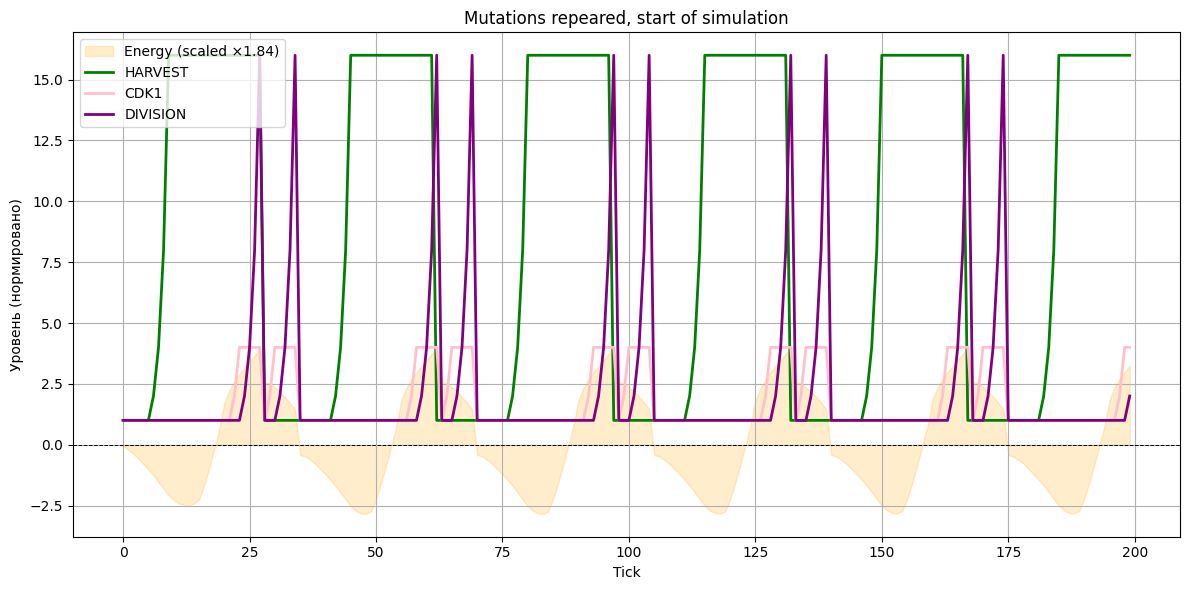

In [11]:
plot_gene_dynamics(df.iloc[:200, :], title="Mutations repeared, start of simulation",
                   genes={"AUTOPHAGY": "blue", 
                          "DETOX": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

In [12]:
# Bigger model with toxins, waste and low mutagenesis, but with normal sensor of mutations
df, all_genes = run_simulation(
    ticks=1000,
    initial_food=1.0,
    initial_energy=0,
    initial_cell_num=1,
    support_cell_num=1000,
    energy_cost=0.001,
    mutation_chance=0.001,
    protein_stability=0.8,
    cellular_products={
        "Wastetoxin": ("energy",  0.1),   # 0.1 * energy, spent for TPM
        "CytokineX":  ("TPMsum",  0.001),  # 0.05 * sum of cell's TPM
        "FooMol":     ("FOODSENS", 0.001),  # 0.2 * TPM of FOODSENS gene (only when FOODSENS active)
        "CellProduct":("CELLPROD", 0.03)
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.2)), 
        "RNAtoxin":    (-2, ("TPM", 0.1)),
        "Wastetoxin": (-3, ("common", 0.001)),
        "CytokineX":     (-3, ("energy",  0.0001)),
        "CellProduct":(-3, ("energy", 0.003))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "TOXSENS":  (2,  "qual", "wk", "wk", 50, ["DIVISION == 'inactive'"], ["Toxin < -2.9", "DIVISION == 'active'"], ("toxsens", 0.01)),
        "TOXNONSENS":  (2,  "qual", "wk", "av", 50, ["Energy <= -1"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("toxsens", 0.1)),
        "MUTSENS":    (2, "qual", "st", "av", 50, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 0.1)),
        "STRESSRESP": (5,  "qual", "wk", "av", 50, ["Energy <= -1", "DIVISION == 'inactive'"], ["Energy >= -1", "CDK1 == 'active'", "DIVISION == 'active'"], ("energy", 0.002)),
        "FUNAKTIV":   (4,  "qual", "av", "av", 50, ["Energy >= 0"], ["Energy < 0", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 50,["Energy <= 0", "FOODSENS == 'active'"], ["Energy >= 1", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.001)),
        "FEED":    (2,  "quan", "st", "st", 50,["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.002)),
        "AUTOPHAGY":  (2,  "quan", "av", "av", 50,["STRESSRESP == 'active'"], ["Energy >= -1", "DIVISION == 'active'"], ("process", 0.0005)),
        "PROTREP":    (4,  "quan", "st", "av", 50,["AUTOPHAGY == 'active'", "Energy <= -1.5"], ["Energy >= 1", "DIVISION == 'active'"], ("process", 0.001)),
        "DETOX":   (2,  "quan", "av", "av", 50,["Toxin_detected == True"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("detox", 0.01)),
        "DETOXX":   (2,  "quan", "st", "st", 50,["Toxin_detected == True", "Toxin >= -1"], ["Toxin <= -2", "CDK1 == 'active'", "DIVISION == 'active'"], ("detox", 1)),
        "CELLPROD": (2,  "quan", "st", "st", 50,["KINFUNK == 'active'"], ["Toxin > 1.5", "STRESSRESP == 'active'", "Energy <= -0.5", "DIVISION == 'active'"], ("energy", 0.005)),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 50,["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
        "KINTOX":    (3, "qual", "av", "wk", 50,["Toxin_detected == True"], ["Toxin_detected == False", "DIVISION == 'active'"], False),
        "KINSTRESS": (3, "qual", "av", "wk", 50,["STRESSRESP == 'active'"], ["Energy > 0", "DIVISION == 'active'"], False),
        "KINFUNK": (3, "qual", "av", "wk", 50,["FUNAKTIV == 'active'"], ["KINFUNK == 'active'", "STRESSRESP == 'active'", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (2,  "qual", "wk", "wk", 50,["Energy >= 1.25"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 50,["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (6, "qual", "av", "av", 50,["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

C:\Users\vsevo\AppData\Local\Temp\ipykernel_15664\4242402357.py:407: RuntimeWarning: overflow encountered in multiply
  record.update({n: round(v, 3) for n, v in env_products.items()})
C:\Users\vsevo\AppData\Local\Temp\ipykernel_15664\4242402357.py:302: RuntimeWarning: overflow encountered in scalar multiply
  env_products[name] *= cell_count


,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-2.998,-2.979,-3.000,-3.0,-2.0,-2.0,-0.06,1,False,...,1.0,1.0,1.000000,1.000000,1,1.0,1.0,3.945666,1.0,0
1,1.0,-2.995,-2.951,-3.000,-3.0,-2.0,-2.0,-0.13,1,False,...,1.0,1.0,1.000000,1.000000,1,1.0,1.0,15.568281,1.0,1
2,1.0,-2.990,-2.899,-3.000,-3.0,-2.0,-2.0,-0.22,1,False,...,1.0,1.0,1.972832,1.000000,1,1.0,1.0,15.782659,1.0,2
3,1.0,-2.984,-2.842,-3.000,-3.0,-2.0,-2.0,-0.32,1,False,...,1.0,1.0,3.892066,1.000000,1,1.0,1.0,15.782654,1.0,3
4,1.0,-2.977,-2.771,-3.000,-3.0,-2.0,-2.0,-0.42,1,False,...,1.0,1.0,3.945662,1.000000,1,1.0,1.0,15.782648,1.0,4
5,1.0,-2.970,-2.696,-3.000,-3.0,-2.0,-2.0,-0.53,1,False,...,1.0,1.0,3.945661,1.000000,1,1.0,1.0,15.782642,1.0,5
6,1.0,-2.961,-2.607,-3.000,-3.0,-2.0,-2.0,-0.66,1,False,...,1.0,1.0,3.945659,1.000000,1,1.0,1.0,15.782635,1.0,6
7,1.0,-2.947,-2.469,-2.992,-3.0,-2.0,-2.0,-0.69,1,False,...,1.0,1.0,3.945656,1.000000,1,1.0,1.0,15.782623,1.0,7
8,1.0,-2.932,-2.320,-2.977,-3.0,-2.0,-2.0,-0.63,1,False,...,1.0,1.0,3.945653,1.000000,1,1.0,1.0,15.782611,1.0,8
9,1.0,-2.917,-2.169,-2.961,-3.0,-2.0,-2.0,-0.50,1,False,...,1.0,1.0,3.945649,1.000000,1,1.0,1.0,15.782598,1.0,9


In [13]:
df.tail(15)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
985,1.0,-2.878,-1.779,-inf,-2.045,-3.0,-3.0,0.35,4835703278458516698824704,False,...,1.000000,3.979860,3.979860,1.989930,1,1.000000,1.000000,15.919441,1.000000,985
986,1.0,-2.869,-1.687,-inf,-1.925,-3.0,-3.0,0.28,4835703278458516698824704,False,...,1.000000,3.979858,3.979858,3.959820,1,1.000000,1.000000,15.919432,1.000000,986
987,1.0,-2.857,-1.566,-inf,-1.806,-3.0,-3.0,0.15,4835703278458516698824704,False,...,1.000000,3.979855,3.979855,3.979855,1,1.989928,1.000000,15.919421,1.000000,987
988,1.0,-2.835,-1.345,-inf,-1.687,-3.0,-3.0,0.11,4835703278458516698824704,False,...,1.000000,3.979850,3.979850,3.979850,1,3.959807,1.000000,15.919401,1.000000,988
989,1.0,-2.813,-1.114,-inf,-1.569,-3.0,-3.0,0.18,4835703278458516698824704,False,...,1.000000,3.979845,3.979845,3.979845,1,1.000000,1.000000,15.919381,1.000000,989
990,1.0,-2.794,-0.886,-inf,-1.453,-3.0,-3.0,0.31,4835703278458516698824704,False,...,3.979840,3.979840,3.979840,3.979840,1,1.000000,1.000000,15.919361,1.000000,990
991,1.0,-2.775,-0.655,-inf,-1.339,-3.0,-3.0,0.49,4835703278458516698824704,False,...,15.839111,3.979836,3.979836,3.979836,1,1.989918,1.000000,15.919343,1.000000,991
992,1.0,-2.804,-0.474,-inf,-1.272,-3.0,-3.0,0.66,4835703278458516698824704,False,...,63.037176,3.979843,3.979843,7.919561,1,3.959780,1.000000,15.919372,1.000000,992
993,1.0,-2.971,-0.460,-inf,-1.426,-3.0,-3.0,0.87,4835703278458516698824704,True,...,63.678084,3.979880,1.000000,15.759452,1,1.000000,1.000000,15.919521,1.000000,993
994,1.0,-2.971,-1.350,-inf,-2.486,-3.0,-3.0,1.08,4835703278458516698824704,True,...,63.678083,3.979880,1.000000,31.360365,1,1.000000,1.000000,15.919521,1.000000,994


In [14]:
# Создадим зависимость детоксикации и выработки клеточных продуктов от количества клеток.

In [15]:
# Genes, protected from mutagenesis
EXCLUDED_FROM_MUTAGENESIS = {"MUTGUARD"}

# === Helper functions ===

def cond_all(conds, vars_):
    return all(eval(c, {}, vars_) for c in conds)

def cond_any(conds, vars_):
    return any(eval(c, {}, vars_) for c in conds)

def grow_and_cap(expr, promoter, enhancer):
    if promoter == 'wk':
        new = expr + 1
    elif promoter == 'av':
        new = expr * 2
    elif promoter == 'st':
        new = expr * 4
    else:
        new = expr
    cap = {'wk': 4, 'av': 16, 'st': 64}.get(enhancer, 64)
    return min(new, cap)

def gene_attempts(expr=12):  # Number of attempts a protein has to perform its function.
    return 3 + int(expr // 12)
    
# def toxin_effect(sigma, base_effect=0.4, k=0.01):
#     return (2 * base_effect) / (1 + np.exp(-k * sigma))
def toxin_effect(sigma, base_effect=0.4, k=0.01):
    return (base_effect * np.exp(sigma))

def detect_effect(sigma, detect_effect=0.05, k=1):
    return (k * np.exp(sigma)) / (64 * detect_effect)

def size_modifier(size_kDa: float ) -> float:  # Белок веса 150 кДа и более развалится в 4 раза быстрее, чем белок весом 10 кДа
    if size_kDa <= 10:
        return 1
    if size_kDa >= 150:
        return 0.25
    # линейная интерполяция: factor = 0.25 + (150 - size) / 140
    return 0.25 + (150 - size_kDa) / 140.0

# === State initialization ===

def initialize_state(receptors, metabolism, kinases, cell_cycle, division, initial_energy, initial_food):
    all_genes = {**receptors, **metabolism, **kinases, **cell_cycle, **division}
    gene_list = list(all_genes.keys())
    return {
        "all_genes": all_genes,
        "gene_list": gene_list,
        "gene_expr": {g: 1 for g in gene_list},
        "gene_status": {g: "inactive" for g in gene_list},
        "gene_prot": {g: 0.0 for g in gene_list},
        "deact_delay": {g: False for g in gene_list},
        "energy": initial_energy,
        "food": initial_food,
        "toxin_detected": False,
        "expressed_flag": {g: False for g in gene_list},
        "mut_detected": False,
        "genes": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
        "reference_genome": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
    }

# === Toxin logic ===

def evaluate_toxins(toxins: dict, toxin_k: float):
    """
    Computes the effects of toxins.
    Returns: tox_penalties, tox_levels
    """
    tox_penalties = {}
    tox_levels = {}
    for name, (sigma, (param, base_eff)) in toxins.items():
        tox_levels[name] = sigma
        eff = toxin_effect(sigma, base_eff, toxin_k)
        if param == "common":
            for p in ["energy", "TPM"]:
                tox_penalties[p] = tox_penalties.get(p, 0.0) + eff
        else:
            tox_penalties[param] = tox_penalties.get(param, 0.0) + eff
    return tox_penalties, tox_levels

# === Logic of cellular products (including toxic ones) ===

def generate_cellular_products(
    prev_expr: dict,
    prev_status: dict,
    cellular_products: dict,
    env_products: dict,
    toxins: dict,
    energy_spent: float,
    TPM_sum: float,
    cell_count: int,
    support_ratio: float
) -> Tuple[dict, dict]:
    """
    Step 2. Generate cellular products, scale them by number of cells,
    and increase sigma of toxins.
    """
    for name, (mode, coeff) in cellular_products.items():
        # 1) считаем дельту на одну клетку
        if mode == "energy":
            delta_per_cell = coeff * energy_spent
        elif mode == "TPMsum":
            delta_per_cell = coeff * TPM_sum
        elif mode in prev_status:
            delta_per_cell = coeff * prev_expr[mode] if prev_status[mode] == "active" else 0.0
        else:
            raise ValueError(f"Unknown production mode '{mode}' for product '{name}'")

        # 2) масштабируем и по числу клеток, и по загрузке
        total_delta = delta_per_cell * cell_count * support_ratio

        # 3) аккумулируем в env_products
        env_products[name] = env_products.get(name, -3.0) + total_delta

        # 4) обновляем токсичность, если этот продукт токсин
        if name in toxins:
            sigma, (p, b) = toxins[name]
            toxins[name] = (sigma + total_delta, (p, b))

    return env_products, toxins

# === Gene logic ===

def process_gene_functions(
    all_genes: dict,
    gene_list: list,
    prev_status: dict,
    prev_expr: dict,
    new_expr: dict,
    gene_prot: dict,
    energy: float,
    toxins: dict,
    state: dict
) -> Tuple[bool, float, float, dict]:
    division_happened = False
    division_cost = 0.0

    for g, record in all_genes.items():
        thr, mode, prom, enh, size_kDa, on_cond, off_cond, func = record
        
        if not func:
            continue

        ftype, val = func

        # 1) Проверяем, накопился ли белок до порога thr
        if gene_prot[g] < thr:  # Если нет, функция не выполняется вообще
            continue

        # 2) Если накопленного протеина достаточно, запускаем функцию.
        #    Все функции теперь получают "eff = gene_prot[g]".
        eff_prot = gene_prot[g]
        
        if ftype == "energy":
            energy += eff_prot * val

        elif ftype == "process":
            to_proc, rem = eff_prot, 0.0
            for tgt in gene_list:
                if tgt == g or gene_prot[tgt] <= 0 or to_proc <= 0:
                    continue
                cut = min(gene_prot[tgt], to_proc)
                gene_prot[tgt] -= cut
                to_proc     -= cut
                rem         += cut
            energy += rem * val

        elif ftype == "RNAdigest":
            to_dig, dig = eff_prot, 0.0
            for tgt in gene_list:
                if to_dig <= 0:
                    break
                av = new_expr[tgt] - 1
                if av <= 0:
                    continue
                cut = min(av, to_dig)
                new_expr[tgt] -= cut
                to_dig       -= cut
                dig          += cut
            energy += dig * val

        elif ftype == "div":
            division_cost    += val
            division_happened = True

        elif ftype == "detox":
            support_ratio = state["cell_count"] / state["support_cell_num"]
            detox_power   = (eff_prot / 64) * val * support_ratio
            for name in toxins:
                sigma, (param, base_eff) = toxins[name]
                new_sigma = max(-3, sigma - detox_power)
                toxins[name] = (new_sigma, (param, base_eff))

        # --- mutation sensor ---
        elif ftype == "mutsens":
            sens_chance = val
            attempts = gene_attempts(eff_prot)
            ref  = state["reference_genome"]
            curr = state["genes"]

            found = False
            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene] and random.random() < sens_chance:
                        found = True
                        break
                if found:
                    break
            if found:
                state["mut_detected"] = True

        # --- mutation repair ---
        elif ftype == "mutrep" and state.get("mut_detected", False):
            rep_chance = val
            attempts = gene_attempts(eff_prot)
            ref  = state["reference_genome"]  # “normal” genome prior to the last division
            curr = state["genes"]             # “physical” copy currently affected by mutations

            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene]:  # found a gene where current != reference
                        if random.random() < rep_chance:
                            curr[gene] = ref[gene]
                        elif random.random() < rep_chance:
                            curr[gene] = mutate_gene(curr[gene])
            # print(f"[MUTREP] gene={g}, attempts={attempts}, ref!=curr for genes:",  # Logging repairation
            #     [x for x in ref if curr[x]!=ref[x]])                                # Logging repairation

    return division_happened, division_cost, energy, toxins

# === Mutagenesis logic ===

def mutate_genes(all_genes: dict, mutation_chance: float) -> dict:
    """
    Randomly mutates some genes,
    but skips those listed in EXCLUDED_FROM_MUTAGENESIS.
    """
    new_genes = copy.deepcopy(all_genes)
    promoters = ['wk', 'av', 'st']
    enhancers = ['wk', 'av', 'st']
    
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in new_genes.items():
        # skip if this gene is in the exclusion list
        if g in EXCLUDED_FROM_MUTAGENESIS:
            continue

        if random.random() < mutation_chance:
            mutation_type = random.choice(['threshold', 'promoter', 'enhancer'])

            if mutation_type == 'threshold':
                delta = random.choice([-1, 1])
                thr = max(1, thr + delta)

            elif mutation_type == 'promoter':
                prom = random.choice(promoters)

            elif mutation_type == 'enhancer':
                enh = random.choice(enhancers)

            new_genes[g] = (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func)

    return new_genes

def mutate_gene(gene_record):
    thr, mode, prom, enh, size_kDa, on_cond, off_cond, func = gene_record
    promoters = ['wk', 'av', 'st']
    enhancers = ['wk', 'av', 'st']
    mutation_type = random.choice(['threshold','promoter','enhancer'])
    if mutation_type == 'threshold':
        thr = max(1, thr + random.choice([-1,1]))
    elif mutation_type == 'promoter':
        prom = random.choice(promoters)
    else:
        enh = random.choice(enhancers)
    return (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func)

# === One simulation step ===

def simulate_tick(state, toxins, energy_cost, toxin_k, cellular_products, env_products, protein_stability):
    
    # 1. Unpack state
    all_genes      = state["all_genes"]
    gene_list      = state["gene_list"]
    prev_expr      = state["gene_expr"]
    prev_status    = state["gene_status"]
    prev_prot      = state["gene_prot"]
    deact_delay    = state["deact_delay"]
    energy         = state["energy"]
    food           = state["food"]
    prev_expressed = state["expressed_flag"]
    cell_count      = state["cell_count"]
    support_level   = state["support_cell_num"]
    support_ratio   = cell_count / support_level

    # 2. TPM costs
    TPM_sum = sum(prev_expr.values())
    tpm_cost = TPM_sum * energy_cost
    energy_spent = tpm_cost

    # 3. Products and toxins
    support_ratio = cell_count / state["support_cell_num"]
    env_products, toxins = generate_cellular_products(
        prev_expr, prev_status,
        cellular_products, env_products,
        toxins,
        energy_spent, TPM_sum,
        cell_count, support_ratio
    )
    tox_penalties, tox_levels = evaluate_toxins(toxins, toxin_k)
    total_toxins = max(tox_levels.values())

    # 4. Toxin detection
    toxin_detected = False
    for g, (_, _, _, _, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if func and func[0] == "toxsens" and prev_status[g] == "active":
            sens_prob = detect_effect(total_toxins, detect_effect=func[1], k=prev_expr[g])
            if sens_prob > 1:
                toxin_detected = True
                break

    # 5. Toxicity penalty
    if "energy" in tox_penalties:
        energy -= tox_penalties["energy"]

    # 6. Local variables
    local = {
        "Energy": energy,
        "Food": food,
        "Toxin": total_toxins,
        "Toxin_detected": toxin_detected
    }
    local.update(prev_status)

    # 7. Flags
    new_expressed = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        stop_cond  = cond_any(off_cond, local)
        start_cond = cond_all(on_cond, local) and not stop_cond
        new_expressed[g] = (prev_expressed[g] and not stop_cond) or start_cond
    had_off = {g: cond_any(all_genes[g][6], local) for g in gene_list}
    
    # 8. Expression
    new_expr = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if new_expressed[g]:
            val  = grow_and_cap(prev_expr[g], prom, enh)
            tpen = 1 - min(tox_penalties.get("TPM", 0.0), 1)
            new_expr[g] = max(1, val * tpen)
        else:
            new_expr[g] = 1

    # 9. Status
    new_status = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if deact_delay[g]:
            new_status[g] = "inactive"
            deact_delay[g] = False
        elif prev_status[g] == "active":
            if had_off[g]:
                new_status[g] = "active"
                deact_delay[g] = True
            else:
                new_status[g] = "active"
        else:
            new_status[g] = (
                "active"
                if (not had_off[g] and cond_all(on_cond, local) and new_expr[g] >= thr)
                else "inactive"
            )

    # 11. Protein dynamics
    gene_prot = {}
    for g in gene_list:
        base_stab = protein_stability.get(g, 1.0)
        # читаем вес из all_genes[g][4]:
        size_kDa = state["all_genes"][g][4]
        stab = base_stab * size_modifier(size_kDa)

        decayed = prev_prot[g] * stab
        added = max(0, prev_expr[g] - 1)
        gene_prot[g] = decayed + added

    # 12. Выполнение функций (теперь на основе накопленного gene_prot):
    division_happened, division_cost, energy, toxins = process_gene_functions(
        all_genes, gene_list, prev_status,
        prev_expr, new_expr, gene_prot,
        energy, toxins,
        state
    )

    # 13. Division
    if division_happened:
         # optional: run repair again to fix any mutations that would otherwise be inherited
        state["reference_genome"] = copy.deepcopy(state["genes"])
        state["mut_detected"] = False
        for g in gene_list:
            new_expr[g]   = 1
            new_status[g] = "inactive"
            gene_prot[g]  = 0.0
            deact_delay[g]= False
        toxin_detected = False
        state["cell_count"] = state["cell_count"] * 2

    # 14. Final energy deduction
    energy -= sum(new_expr.values()) * energy_cost
    energy -= division_cost

    # 14.5. Потребление пищи
    # Не реализовано

    # 15. Logging and return
    record = {"Food": round(food, 2)}
    record.update({n: round(v, 3) for n, v in env_products.items()})
    record.update({n: round(tox_levels[n], 3) for n in tox_levels})
    record["Energy"] = round(energy, 2)
    record["CellCount"] = state["cell_count"]
    record["mut_detected"] = state['mut_detected']
    record["tox_detected"] = state['toxin_detected']
    record.update(new_expr)

    next_state = {
        "all_genes":      all_genes,
        "gene_list":      gene_list,
        "gene_expr":      new_expr,
        "gene_status":    new_status,
        "gene_prot":      gene_prot,
        "deact_delay":    deact_delay,
        "energy":         energy,
        "food":           food,
        "toxin_detected": toxin_detected,
        "expressed_flag": new_expressed,
        "mut_detected":   state["mut_detected"],
        "genes":          state["genes"],
        "reference_genome": state["reference_genome"],
    }
    next_state["cell_count"]       = state["cell_count"]
    next_state["support_cell_num"] = state["support_cell_num"]
    stop = energy <= -3
    return next_state, record, stop, env_products, toxins

# === Main function ===

def run_simulation(
    ticks: int = 50,
    initial_food: float = 1.0,
    initial_energy: float = 1.0,
    energy_cost: float = 0.01,
    initial_cell_num: int = 1,
    support_cell_num: int = 1000,
    receptors: dict = {},
    metabolism: dict = {},
    kinases: dict = {},
    cell_cycle: dict = {},
    division: dict = {},
    toxins: dict = None,
    toxin_k: float = 1,
    cellular_products: dict = None,
    mutation_chance: float = 0.0,
    protein_stability=None,
) -> Tuple[pd.DataFrame, dict]:

    # Initialization
    state = initialize_state(
        receptors, metabolism, kinases, cell_cycle, division,
        initial_energy, initial_food
    )
    state["cell_count"] = initial_cell_num
    state["support_cell_num"] = support_cell_num
    records = []
    toxins = toxins or {}
    cellular_products = cellular_products or {}
    if isinstance(protein_stability, (int, float)):
        protein_stability = {g: protein_stability for g in state["gene_list"]}
    elif protein_stability is None:
        protein_stability = {g: 1.0 for g in state["gene_list"]}


    # env_products — environment level (sigma) for each cellular product
    env_products = {name: -3.0 for name in cellular_products.keys()}

    # Main loop
    for tick in range(ticks):
        if mutation_chance > 0:
            state["genes"] = mutate_genes(state["genes"], mutation_chance)
        state["all_genes"] = state["genes"]
        state, record, stop, env_products, toxins = simulate_tick(
            state=state,
            toxins=toxins,
            energy_cost=energy_cost,
            toxin_k=toxin_k,
            cellular_products=cellular_products,
            env_products=env_products,
            protein_stability=protein_stability
        )
        record["Tick"] = tick
        records.append(record)
        if stop:
            print(f"Cell died at tick {tick}, energy={state['energy']:.2f}")
            break

    return pd.DataFrame(records), state["all_genes"]

In [16]:
# Bigger model with toxins, waste and low mutagenesis, but with normal sensor of mutations
df, all_genes = run_simulation(
    ticks=1000,
    initial_food=1.0,
    initial_energy=0,
    initial_cell_num=1,
    support_cell_num=1000,
    energy_cost=0.0005,
    mutation_chance=0.001,
    protein_stability=0.8,
    cellular_products={
        "Wastetoxin": ("energy",  0.01),   # 0.1 * energy, spent for TPM
        "CytokineX":  ("TPMsum",  0.001),  # 0.05 * sum of cell's TPM
        "FooMol":     ("FOODSENS", 0.001),  # 0.2 * TPM of FOODSENS gene (only when FOODSENS active)
        "CellProduct":("CELLPROD", 0.03)
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.2)), 
        "RNAtoxin":    (-2, ("TPM", 0.1)),
        "Wastetoxin": (-3, ("common", 0.001)),
        "CytokineX":     (-3, ("energy",  0.00)),
        "CellProduct":(-3, ("energy", 0.00))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "TOXSENS":  (2,  "qual", "wk", "wk", 50, ["DIVISION == 'inactive'"], ["Toxin < -2.9", "DIVISION == 'active'"], ("toxsens", 0.01)),
        "TOXNONSENS":  (2,  "qual", "wk", "av", 50, ["Energy <= -1"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("toxsens", 0.1)),
        "MUTSENS":    (2, "qual", "st", "av", 50, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 0.1)),
        "STRESSRESP": (5,  "qual", "wk", "av", 50, ["Energy <= -1", "DIVISION == 'inactive'"], ["Energy >= -1", "CDK1 == 'active'", "DIVISION == 'active'"], ("energy", 0.002)),
        "FUNAKTIV":   (4,  "qual", "av", "av", 50, ["Energy >= 0"], ["Energy < 0", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 50, ["Energy <= 0", "FOODSENS == 'active'"], ["Energy >= 1", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.001)),
        "FEED":    (2,  "quan", "st", "st", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.002)),
        "AUTOPHAGY":  (2,  "quan", "av", "av", 50, ["STRESSRESP == 'active'"], ["Energy >= -1", "DIVISION == 'active'"], ("process", 0.0005)),
        "PROTREP":    (4,  "quan", "st", "av", 50, ["AUTOPHAGY == 'active'", "Energy <= -1.5"], ["Energy >= 1", "DIVISION == 'active'"], ("process", 0.001)),
        "DETOX":   (2,  "quan", "av", "av", 50, ["Toxin_detected == True"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("detox", 0.01)),
        "DETOXX":   (2,  "quan", "st", "st", 50, ["Toxin_detected == True", "Toxin >= -1"], ["Toxin <= -2", "CDK1 == 'active'", "DIVISION == 'active'"], ("detox", 1)),
        "CELLPROD": (2,  "quan", "st", "st", 50, ["KINFUNK == 'active'"], ["Toxin > 1.5", "STRESSRESP == 'active'", "Energy <= -0.5", "DIVISION == 'active'"], ("energy", 0.005)),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 50, ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
        "KINTOX":    (3, "qual", "av", "wk", 50, ["Toxin_detected == True"], ["Toxin_detected == False", "DIVISION == 'active'"], False),
        "KINSTRESS": (3, "qual", "av", "wk", 50, ["STRESSRESP == 'active'"], ["Energy > 0", "DIVISION == 'active'"], False),
        "KINFUNK": (3, "qual", "av", "wk", 50, ["FUNAKTIV == 'active'"], ["KINFUNK == 'active'", "STRESSRESP == 'active'", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (2,  "qual", "wk", "wk", 50, ["Energy >= 1.25"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (6, "qual", "av", "av", 50, ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

C:\Users\vsevo\AppData\Local\Temp\ipykernel_15664\3319043850.py:30: RuntimeWarning: overflow encountered in exp
  return (base_effect * np.exp(sigma))
C:\Users\vsevo\AppData\Local\Temp\ipykernel_15664\3319043850.py:30: RuntimeWarning: invalid value encountered in scalar multiply
  return (base_effect * np.exp(sigma))
C:\Users\vsevo\AppData\Local\Temp\ipykernel_15664\3319043850.py:33: RuntimeWarning: overflow encountered in exp
  return (k * np.exp(sigma)) / (64 * detect_effect)


,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.04,1,False,...,1.0,1.0,1.000000,1.0,1,1.000000,1.000000,3.945667,1.0,0
1,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.09,1,False,...,1.0,1.0,1.000000,1.0,1,1.000000,1.000000,15.568286,1.0,1
2,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.15,1,False,...,1.0,1.0,1.972833,1.0,1,1.000000,1.000000,15.782667,1.0,2
3,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.21,1,False,...,1.0,1.0,3.892072,1.0,1,1.000000,1.000000,15.782667,1.0,3
4,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.28,1,False,...,1.0,1.0,3.945667,1.0,1,1.000000,1.000000,15.782667,1.0,4
5,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.34,1,False,...,1.0,1.0,3.945667,1.0,1,1.000000,1.000000,15.782667,1.0,5
6,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.41,1,False,...,1.0,1.0,3.945667,1.0,1,1.000000,1.000000,15.782667,1.0,6
7,1.0,-3.0,-2.999,-3.0,-3.0,-2.0,-2.0,-0.36,1,False,...,1.0,1.0,3.945667,1.0,1,1.000000,1.000000,15.782667,1.0,7
8,1.0,-3.0,-2.999,-3.0,-3.0,-2.0,-2.0,-0.23,1,False,...,1.0,1.0,3.945667,1.0,1,1.000000,1.000000,15.782667,1.0,8
9,1.0,-3.0,-2.999,-3.0,-3.0,-2.0,-2.0,-0.02,1,False,...,1.0,1.0,3.945667,1.0,1,1.000000,1.000000,15.782667,1.0,9


In [17]:
df.iloc[79:, :].head(15)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
79,1.0,-2.809,35.404,-2.995,-1.873,-2.001,-2.001,1.75,512,False,...,1.000000,1.0,1.000000,1.000000,1,1.000000,1.972835,3.945669,1.000000,79
80,1.0,-2.770,43.218,-2.995,-1.873,-2.001,-2.001,1.70,512,False,...,1.000000,1.0,1.000000,1.000000,1,1.000000,2.932449,15.568269,1.000000,80
81,1.0,-2.695,58.132,-2.995,-1.873,-2.001,-2.001,1.63,512,False,...,1.000000,1.0,1.000000,1.972820,1,1.000000,3.879007,15.782561,1.972820,81
82,1.0,-2.605,76.185,-2.995,-1.873,-2.001,-2.001,1.56,512,False,...,1.000000,1.0,1.000000,3.891994,1,1.972807,3.945615,15.782459,3.891994,82
83,1.0,-2.481,101.042,-2.995,-1.873,-2.001,-2.001,1.48,512,False,...,1.000000,1.0,1.000000,3.945576,1,3.891931,3.945576,15.782303,7.678079,83
84,1.0,-2.343,128.623,-2.995,-1.874,-2.001,-2.001,0.44,1024,False,...,1.000000,1.0,1.000000,1.000000,1,1.000000,1.000000,1.000000,1.000000,84
85,1.0,-2.234,150.642,-2.995,-1.874,-2.002,-2.002,0.40,1024,False,...,1.000000,1.0,1.000000,1.000000,1,1.000000,1.000000,3.945539,1.000000,85
86,1.0,-2.082,180.879,-2.995,-1.874,-2.002,-2.002,0.35,1024,False,...,1.000000,1.0,1.000000,1.000000,1,1.000000,1.000000,15.567000,1.000000,86
87,1.0,-1.794,238.507,-2.995,-1.874,-2.002,-2.002,0.28,1024,False,...,3.945302,1.0,1.972651,1.972651,1,1.000000,1.000000,15.781209,1.000000,87
88,1.0,-1.433,310.782,-2.995,-1.874,-2.002,-2.002,0.21,1024,False,...,15.564268,1.0,3.891067,3.891067,1,1.972506,1.000000,15.780051,1.000000,88


In [18]:
df.tail(15)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
985,1.0,-1.790,213237.670,-2.995,-3.0,-3.0,-3.0,NaN,1024,True,...,63.670673,1.0,3.979417,3.979417,1,3.958944,1.0,15.917668,1.0,985
986,1.0,-1.779,213477.420,-2.995,-3.0,-3.0,-3.0,NaN,1024,True,...,63.670563,1.0,3.979410,3.979410,1,1.000000,1.0,15.917641,1.0,986
987,1.0,-1.795,213714.066,-2.995,-3.0,-3.0,-3.0,NaN,1024,True,...,63.670729,1.0,3.979421,3.979421,1,1.000000,1.0,15.917682,1.0,987
988,1.0,-1.795,213950.714,-2.995,-3.0,-3.0,-3.0,NaN,1024,True,...,63.670729,1.0,3.979421,3.979421,1,1.989710,1.0,15.917682,1.0,988
989,1.0,-1.790,214188.399,-2.995,-3.0,-3.0,-3.0,NaN,1024,True,...,63.670673,1.0,3.979417,3.979417,1,3.958944,1.0,15.917668,1.0,989
990,1.0,-1.779,214428.149,-2.995,-3.0,-3.0,-3.0,NaN,1024,True,...,63.670563,1.0,3.979410,3.979410,1,1.000000,1.0,15.917641,1.0,990
991,1.0,-1.795,214664.795,-2.995,-3.0,-3.0,-3.0,NaN,1024,True,...,63.670729,1.0,3.979421,3.979421,1,1.000000,1.0,15.917682,1.0,991
992,1.0,-1.795,214901.442,-2.995,-3.0,-3.0,-3.0,NaN,1024,True,...,63.670729,1.0,3.979421,3.979421,1,1.989710,1.0,15.917682,1.0,992
993,1.0,-1.790,215139.127,-2.995,-3.0,-3.0,-3.0,NaN,1024,True,...,63.670673,1.0,3.979417,3.979417,1,3.958944,1.0,15.917668,1.0,993
994,1.0,-1.779,215378.877,-2.995,-3.0,-3.0,-3.0,NaN,1024,True,...,63.670563,1.0,3.979410,3.979410,1,1.000000,1.0,15.917641,1.0,994


In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Food,1000.0,1.000000,0.000000,1.00,1.000000,1.000000,1.000000,1.000000
Wastetoxin,1000.0,-1.886234,0.336863,-3.00,-1.795000,-1.795000,-1.790000,-0.388000
CytokineX,1000.0,98774.303749,67204.067958,-3.00,38491.671500,97843.489500,157204.614500,216566.253000
FooMol,1000.0,-2.995205,0.000982,-3.00,-2.995000,-2.995000,-2.995000,-2.995000
CellProduct,1000.0,-2.947146,0.233484,-3.00,-3.000000,-3.000000,-3.000000,-1.872000
Energotoxin,1000.0,-2.909381,0.286726,-3.00,-3.000000,-3.000000,-3.000000,-2.000000
RNAtoxin,1000.0,-2.909381,0.286726,-3.00,-3.000000,-3.000000,-3.000000,-2.000000
Energy,91.0,2.767033,2.749729,-0.41,0.260000,2.070000,4.470000,8.530000
CellCount,1000.0,944.223000,266.659927,1.00,1024.000000,1024.000000,1024.000000,1024.000000
ENGSENS,1000.0,15.625032,1.929374,1.00,15.917641,15.917668,15.917682,15.917682


In [20]:
# Придётся "клиповать" сигму

In [21]:
def toxin_effect(sigma, base_effect=0.4, k=0.01):
    return (base_effect * np.exp(sigma))

In [22]:
for σ in [ -3, 0, 5, 10, 20, 30, 50, 100 ]:
    print(σ, toxin_effect(σ, base_effect=0.4, k=0.01))

-3 0.01991482734714558
0 0.4
5 59.365263641030644
10 8810.586317922687
20 194066078.1639161
30 4274589832609.785
50 2.073882211434829e+21
100 1.0752468567264543e+43


In [27]:
def toxin_effect(sigma, base_effect=0.4, k=0.01):
    return (base_effect * np.exp(max(min(sigma, 10), -10)))  # sigma clamped 

In [28]:
for σ in [ -3, 0, 5, 10, 20, 30, 50, 100 ]:
    print(σ, toxin_effect(σ, base_effect=0.4, k=0.01))

-3 0.01991482734714558
0 0.4
5 59.365263641030644
10 8810.586317922687
20 8810.586317922687
30 8810.586317922687
50 8810.586317922687
100 8810.586317922687


In [ ]:
# Поправил функции-помощники, сделал "клиппинг" сигмы для оценки эффекта

In [165]:
# Genes, protected from mutagenesis
EXCLUDED_FROM_MUTAGENESIS = {"MUTGUARD"}

# === Helper functions ===

def cond_all(conds, vars_):
    return all(eval(c, {}, vars_) for c in conds)

def cond_any(conds, vars_):
    return any(eval(c, {}, vars_) for c in conds)

def grow_and_cap(expr, promoter, enhancer):
    return min(
        expr + 1 if promoter == 'wk' else expr * 2 if promoter == 'av' else expr * 4 if promoter == 'st' else expr, 
        {'wk': 4, 'av': 16, 'st': 64}.get(enhancer, 64)
    )

def gene_attempts(expr=12):  # Number of attempts a protein has to perform its function.
    return 3 + int(expr // 12)

def toxin_effect(sigma, base_effect=0.4, k=0.01):
    return (base_effect * np.exp(max(min(sigma, 3), -8)))  # sigma clamped to avoid infinity effects

def detect_effect(sigma, detect_effect=0.05, k=1):  # sigma clamped to avoid infinity effects
    return (k * np.exp(max(min(sigma, 8), -8))) / (64 * detect_effect)

def size_modifier(size_kDa: float ) -> float:  # Белок веса 150 кДа и более развалится в 4 раза быстрее, чем белок весом 10 кДа
    return (1 if size_kDa <= 10 else 0.25 if size_kDa >= 150 else 0.25 + (150 - size_kDa) / 140.0)

# === State initialization ===

def initialize_state(receptors, metabolism, kinases, cell_cycle, division, initial_energy, initial_food):
    all_genes = {**receptors, **metabolism, **kinases, **cell_cycle, **division}
    gene_list = list(all_genes.keys())
    return {
        "all_genes": all_genes,
        "gene_list": gene_list,
        "gene_expr": {g: 1 for g in gene_list},
        "gene_status": {g: "inactive" for g in gene_list},
        "gene_prot": {g: 0.0 for g in gene_list},
        "deact_delay": {g: False for g in gene_list},
        "energy": initial_energy,
        "food": initial_food,
        "toxin_detected": False,
        "expressed_flag": {g: False for g in gene_list},
        "mut_detected": False,
        "genes": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
        "reference_genome": copy.deepcopy(receptors | metabolism | kinases | cell_cycle | division),
    }

# === Toxin logic ===

def evaluate_toxins(toxins: dict, toxin_k: float):
    tox_penalties = {}
    tox_levels = {}
    for name, (sigma, (param, base_eff)) in toxins.items():
        tox_levels[name] = sigma
        eff = toxin_effect(sigma, base_eff, toxin_k)
        if param == "common":
            for p in ["energy", "TPM"]:
                tox_penalties[p] = tox_penalties.get(p, 0.0) + eff
        else:
            tox_penalties[param] = tox_penalties.get(param, 0.0) + eff
    return tox_penalties, tox_levels

# === Logic of cellular products (including toxic ones) ===

def generate_cellular_products(
    prev_expr: dict,
    prev_status: dict,
    cellular_products: dict,
    env_products: dict,
    toxins: dict,
    energy_spent: float,
    TPM_sum: float,
    cell_count: int,
    support_ratio: float
) -> Tuple[dict, dict]:

    for name, (mode, coeff) in cellular_products.items():
        # 1) считаем дельту на одну клетку
        if mode == "energy":
            delta_per_cell = coeff * energy_spent
        elif mode == "TPMsum":
            delta_per_cell = coeff * TPM_sum
        elif mode in prev_status:
            delta_per_cell = coeff * prev_expr[mode] if prev_status[mode] == "active" else 0.0
        else:
            raise ValueError(f"Unknown production mode '{mode}' for product '{name}'")

        # 2) масштабируем и по числу клеток, и по загрузке
        # total_delta = delta_per_cell * cell_count * support_ratio
        total_delta = delta_per_cell * support_ratio
        # 3) аккумулируем в env_products
        env_products[name] = env_products.get(name, -3.0) + total_delta

        # 4) обновляем токсичность, если этот продукт токсин
        if name in toxins:
            sigma, (p, b) = toxins[name]
            toxins[name] = (sigma + total_delta, (p, b))

    return env_products, toxins

# === Gene logic ===

def process_gene_functions(
    all_genes: dict,
    gene_list: list,
    prev_status: dict,
    prev_expr: dict,
    new_expr: dict,
    gene_prot: dict,
    energy: float,
    toxins: dict,
    state: dict
) -> Tuple[bool, float, float, dict]:
    division_happened = False
    division_cost = 0.0

    for g, record in all_genes.items():
        thr, mode, prom, enh, size_kDa, on_cond, off_cond, func = record
        
        if not func:
            continue

        ftype, val = func

        # 1) Проверяем, накопился ли белок до порога thr
        if gene_prot[g] < thr:  # Если нет, функция не выполняется вообще
            continue

        # 2) Если накопленного протеина достаточно, запускаем функцию. Все функции теперь получают "eff = gene_prot[g]".  
        eff_prot = gene_prot[g]
        
        if ftype == "energy":
            energy += eff_prot * val

        elif ftype == "process":
            to_proc, rem = eff_prot, 0.0
            for tgt in gene_list:
                if tgt == g or gene_prot[tgt] <= 0 or to_proc <= 0:
                    continue
                cut = min(gene_prot[tgt], to_proc)
                gene_prot[tgt] -= cut
                to_proc     -= cut
                rem         += cut
            energy += rem * val

        elif ftype == "RNAdigest":
            to_dig, dig = eff_prot, 0.0
            for tgt in gene_list:
                if to_dig <= 0:
                    break
                av = new_expr[tgt] - 1
                if av <= 0:
                    continue
                cut = min(av, to_dig)
                new_expr[tgt] -= cut
                to_dig       -= cut
                dig          += cut
            energy += dig * val

        elif ftype == "div":
            division_cost    += val
            division_happened = True

        elif ftype == "detox":
            support_ratio = state["cell_count"] / state["support_cell_num"]
            # detox_power   = (eff_prot / 64) * val * support_ratio
            detox_power   = (eff_prot * state["cell_count"] / 64) * val * support_ratio
            for name in toxins:
                sigma, (param, base_eff) = toxins[name]
                new_sigma = max(-3, sigma - detox_power)
                toxins[name] = (new_sigma, (param, base_eff))

        # --- mutation sensor ---
        elif ftype == "mutsens":
            sens_chance = val
            attempts = gene_attempts(eff_prot)
            ref  = state["reference_genome"]
            curr = state["genes"]

            found = False
            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene] and random.random() < sens_chance:
                        found = True
                        break
                if found:
                    break
            if found:
                state["mut_detected"] = True

        # --- mutation repair ---
        elif ftype == "mutrep" and state.get("mut_detected", False):
            rep_chance = val
            attempts = gene_attempts(eff_prot)
            ref  = state["reference_genome"]  # “normal” genome prior to the last division
            curr = state["genes"]             # “physical” copy currently affected by mutations

            for _ in range(attempts):
                for gene in ref:
                    if gene in curr and curr[gene] != ref[gene]:  # found a gene where current != reference
                        if random.random() < rep_chance:
                            curr[gene] = ref[gene]
                        elif random.random() < rep_chance:
                            curr[gene] = mutate_gene(curr[gene])
            # print(f"[MUTREP] gene={g}, attempts={attempts}, ref!=curr for genes:",  # Logging repairation
            #     [x for x in ref if curr[x]!=ref[x]])                                # Logging repairation

    return division_happened, division_cost, energy, toxins

# === Mutagenesis logic ===

def mutate_genes(all_genes: dict, mutation_chance: float) -> dict:
    """
    Randomly mutates some genes,
    but skips those listed in EXCLUDED_FROM_MUTAGENESIS.
    """
    new_genes = copy.deepcopy(all_genes)
    promoters = ['wk', 'av', 'st']
    enhancers = ['wk', 'av', 'st']
    
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in new_genes.items():
        # skip if this gene is in the exclusion list
        if g in EXCLUDED_FROM_MUTAGENESIS:
            continue

        if random.random() < mutation_chance:
            mutation_type = random.choice(['threshold', 'promoter', 'enhancer'])

            if mutation_type == 'threshold':
                delta = random.choice([-1, 1])
                thr = max(1, thr + delta)

            elif mutation_type == 'promoter':
                prom = random.choice(promoters)

            elif mutation_type == 'enhancer':
                enh = random.choice(enhancers)

            new_genes[g] = (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func)

    return new_genes

def mutate_gene(gene_record):
    thr, mode, prom, enh, size_kDa, on_cond, off_cond, func = gene_record
    promoters = ['wk', 'av', 'st']
    enhancers = ['wk', 'av', 'st']
    mutation_type = random.choice(['threshold','promoter','enhancer'])
    if mutation_type == 'threshold':
        thr = max(1, thr + random.choice([-1,1]))
    elif mutation_type == 'promoter':
        prom = random.choice(promoters)
    else:
        enh = random.choice(enhancers)
    return (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func)

# === One simulation step ===

def simulate_tick(state, toxins, energy_cost, toxin_k, cellular_products, env_products, protein_stability):
    
    # 1. Unpack state
    all_genes      = state["all_genes"]
    gene_list      = state["gene_list"]
    prev_expr      = state["gene_expr"]
    prev_status    = state["gene_status"]
    prev_prot      = state["gene_prot"]
    deact_delay    = state["deact_delay"]
    energy         = state["energy"]
    food           = state["food"]
    prev_expressed = state["expressed_flag"]
    cell_count      = state["cell_count"]
    support_level   = state["support_cell_num"]
    support_ratio   = cell_count / support_level

    # 2. TPM costs
    TPM_sum = sum(prev_expr.values())
    tpm_cost = TPM_sum * energy_cost
    energy_spent = tpm_cost

    # 3. Products and toxins
    support_ratio = cell_count / state["support_cell_num"]
    env_products, toxins = generate_cellular_products(
        prev_expr, prev_status,
        cellular_products, env_products,
        toxins,
        energy_spent, TPM_sum,
        cell_count, support_ratio
    )
    tox_penalties, tox_levels = evaluate_toxins(toxins, toxin_k)
    total_toxins = max(tox_levels.values())

    # 4. Toxin detection
    toxin_detected = False
    for g, (_, _, _, _, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if func and func[0] == "toxsens" and prev_status[g] == "active":
            sens_prob = detect_effect(total_toxins, detect_effect=func[1], k=prev_expr[g])
            if sens_prob > 1:
                toxin_detected = True
                break

    # 5. Toxicity penalty
    if "energy" in tox_penalties:
        energy -= tox_penalties["energy"]

    # 6. Local variables
    local = {
        "Energy": energy,
        "Food": food,
        "Toxin": total_toxins,
        "Toxin_detected": toxin_detected
    }
    local.update(prev_status)

    # 7. Flags
    new_expressed = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        stop_cond  = cond_any(off_cond, local)
        start_cond = cond_all(on_cond, local) and not stop_cond
        new_expressed[g] = (prev_expressed[g] and not stop_cond) or start_cond
    had_off = {g: cond_any(all_genes[g][6], local) for g in gene_list}
    
    # 8. Expression
    new_expr = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if new_expressed[g]:
            val  = grow_and_cap(prev_expr[g], prom, enh)
            tpen = 1 - min(tox_penalties.get("TPM", 0.0), 1)
            new_expr[g] = max(1, val * tpen)
        else:
            new_expr[g] = 1

    # 9. Status
    new_status = {}
    for g, (thr, mode, prom, enh, size_kDa, on_cond, off_cond, func) in all_genes.items():
        if deact_delay[g]:
            new_status[g] = "inactive"
            deact_delay[g] = False
        elif prev_status[g] == "active":
            if had_off[g]:
                new_status[g] = "active"
                deact_delay[g] = True
            else:
                new_status[g] = "active"
        else:
            new_status[g] = (
                "active"
                if (not had_off[g] and cond_all(on_cond, local) and new_expr[g] >= thr)
                else "inactive"
            )

    # 11. Protein dynamics
    gene_prot = {}
    for g in gene_list:
        base_stab = protein_stability.get(g, 1.0)
        # читаем вес из all_genes[g][4]:
        size_kDa = state["all_genes"][g][4]
        stab = base_stab * size_modifier(size_kDa)

        decayed = prev_prot[g] * stab
        added = max(0, prev_expr[g] - 1)
        gene_prot[g] = decayed + added

    # 12. Выполнение функций (теперь на основе накопленного gene_prot):
    division_happened, division_cost, energy, toxins = process_gene_functions(
        all_genes, gene_list, prev_status,
        prev_expr, new_expr, gene_prot,
        energy, toxins,
        state
    )

    # 13. Division
    if division_happened:
         # optional: run repair again to fix any mutations that would otherwise be inherited
        state["reference_genome"] = copy.deepcopy(state["genes"])
        state["mut_detected"] = False
        for g in gene_list:
            new_expr[g]   = 1
            new_status[g] = "inactive"
            gene_prot[g]  = 0.0
            deact_delay[g]= False
        toxin_detected = False
        state["cell_count"] = state["cell_count"] * 2

    # 14. Final energy deduction
    energy -= sum(new_expr.values()) * energy_cost
    energy -= division_cost

    # 14.5. Потребление пищи
    # Не реализовано

    # 15. Logging and return
    record = {"Food": round(food, 2)}
    record.update({n: round(v, 3) for n, v in env_products.items()})
    record.update({n: round(tox_levels[n], 3) for n in tox_levels})
    record["Energy"] = round(energy, 2)
    record["CellCount"] = state["cell_count"]
    record["mut_detected"] = state['mut_detected']
    record["tox_detected"] = state['toxin_detected']
    record.update(new_expr)

    next_state = {
        "all_genes":      all_genes,
        "gene_list":      gene_list,
        "gene_expr":      new_expr,
        "gene_status":    new_status,
        "gene_prot":      gene_prot,
        "deact_delay":    deact_delay,
        "energy":         energy,
        "food":           food,
        "toxin_detected": toxin_detected,
        "expressed_flag": new_expressed,
        "mut_detected":   state["mut_detected"],
        "genes":          state["genes"],
        "reference_genome": state["reference_genome"],
    }
    next_state["cell_count"]       = state["cell_count"]
    next_state["support_cell_num"] = state["support_cell_num"]
    stop = energy <= -3
    return next_state, record, stop, env_products, toxins

# === Main function ===

def run_simulation(
    ticks: int = 50,
    initial_food: float = 1.0,
    initial_energy: float = 1.0,
    energy_cost: float = 0.01,
    initial_cell_num: int = 1,
    support_cell_num: int = 1000,
    receptors: dict = {},
    metabolism: dict = {},
    kinases: dict = {},
    cell_cycle: dict = {},
    division: dict = {},
    toxins: dict = None,
    toxin_k: float = 1,
    cellular_products: dict = None,
    mutation_chance: float = 0.0,
    protein_stability=None,
) -> Tuple[pd.DataFrame, dict]:

    # Initialization
    state = initialize_state(
        receptors, metabolism, kinases, cell_cycle, division,
        initial_energy, initial_food
    )
    state["cell_count"] = initial_cell_num
    state["support_cell_num"] = support_cell_num
    records = []
    toxins = toxins or {}
    cellular_products = cellular_products or {}
    if isinstance(protein_stability, (int, float)):
        protein_stability = {g: protein_stability for g in state["gene_list"]}
    elif protein_stability is None:
        protein_stability = {g: 1.0 for g in state["gene_list"]}


    # env_products — environment level (sigma) for each cellular product
    env_products = {name: -3.0 for name in cellular_products.keys()}

    # Main loop
    for tick in range(ticks):
        if mutation_chance > 0:
            state["genes"] = mutate_genes(state["genes"], mutation_chance)
        state["all_genes"] = state["genes"]
        state, record, stop, env_products, toxins = simulate_tick(
            state=state,
            toxins=toxins,
            energy_cost=energy_cost,
            toxin_k=toxin_k,
            cellular_products=cellular_products,
            env_products=env_products,
            protein_stability=protein_stability
        )
        record["Tick"] = tick
        records.append(record)
        if stop:
            print(f"Cell died at tick {tick}, energy={state['energy']:.2f}")
            break

    return pd.DataFrame(records), state["all_genes"]

In [166]:
# Bigger model with toxins, waste and low mutagenesis, but with normal sensor of mutations
df, all_genes = run_simulation(
    ticks=1000,
    initial_food=1.0,
    initial_energy=0,
    initial_cell_num=1,
    support_cell_num=1000,
    energy_cost=0.0005,
    mutation_chance=0.001,
    protein_stability=0.8,
    cellular_products={
        "Wastetoxin": ("energy",  0.01),   # 0.1 * energy, spent for TPM
        "CytokineX":  ("TPMsum",  0.001),  # 0.05 * sum of cell's TPM
        "FooMol":     ("FOODSENS", 0.001),  # 0.2 * TPM of FOODSENS gene (only when FOODSENS active)
        "CellProduct":("CELLPROD", 0.03)
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.2)), 
        "RNAtoxin":    (-2, ("TPM", 0.1)),
        "Wastetoxin": (-3, ("common", 0.001)),
        "CytokineX":     (-3, ("energy",  0.00)),
        "CellProduct":(-3, ("energy", 0.00))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "TOXSENS":  (2,  "qual", "wk", "wk", 50, ["DIVISION == 'inactive'"], ["Toxin < -2.9", "DIVISION == 'active'"], ("toxsens", 0.01)),
        "TOXNONSENS":  (2,  "qual", "wk", "av", 50, ["Energy <= -1"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("toxsens", 0.1)),
        "MUTSENS":    (2, "qual", "st", "av", 50, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 0.1)),
        "STRESSRESP": (5,  "qual", "wk", "av", 50, ["Energy <= -1", "DIVISION == 'inactive'"], ["Energy >= -1", "CDK1 == 'active'", "DIVISION == 'active'"], ("energy", 0.002)),
        "FUNAKTIV":   (4,  "qual", "av", "av", 50, ["Energy >= 0"], ["Energy < 0", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 150, ["Energy <= 0", "FOODSENS == 'active'"], ["Energy >= 1", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.001)),
        "FEED":    (2,  "quan", "st", "st", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.002)),
        "AUTOPHAGY":  (2,  "quan", "av", "av", 50, ["STRESSRESP == 'active'"], ["Energy >= -1", "DIVISION == 'active'"], ("process", 0.0005)),
        "PROTREP":    (4,  "quan", "st", "av", 50, ["AUTOPHAGY == 'active'", "Energy <= -1.5"], ["Energy >= 1", "DIVISION == 'active'"], ("process", 0.001)),
        "DETOX":   (2,  "quan", "av", "av", 50, ["Toxin_detected == True"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("detox", 0.01)),
        "DETOXX":   (2,  "quan", "st", "st", 50, ["Toxin_detected == True", "Toxin >= -1"], ["Toxin <= -2", "CDK1 == 'active'", "DIVISION == 'active'"], ("detox", 1)),
        "CELLPROD": (2,  "quan", "st", "st", 50, ["KINFUNK == 'active'"], ["Toxin > 1.5", "STRESSRESP == 'active'", "Energy <= -0.5", "DIVISION == 'active'"], ("energy", 0.005)),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 50, ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
        "KINTOX":    (3, "qual", "av", "wk", 50, ["Toxin_detected == True"], ["Toxin_detected == False", "DIVISION == 'active'"], False),
        "KINSTRESS": (3, "qual", "av", "wk", 50, ["STRESSRESP == 'active'"], ["Energy > 0", "DIVISION == 'active'"], False),
        "KINFUNK": (3, "qual", "av", "wk", 50, ["FUNAKTIV == 'active'"], ["KINFUNK == 'active'", "STRESSRESP == 'active'", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (2,  "qual", "wk", "wk", 50, ["Energy >= 1.25"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (6, "qual", "av", "av", 50, ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.04,1,False,...,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,3.945667,1.0,0
1,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.09,1,False,...,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,15.568286,1.0,1
2,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.15,1,False,...,1.0,1.0,1.972833,1.0,1.0,1.000000,1.0,15.782667,1.0,2
3,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.21,1,False,...,1.0,1.0,3.892072,1.0,1.0,1.000000,1.0,15.782667,1.0,3
4,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.28,1,False,...,1.0,1.0,3.945667,1.0,1.0,1.000000,1.0,15.782667,1.0,4
5,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.34,1,False,...,1.0,1.0,3.945667,1.0,1.0,1.000000,1.0,15.782667,1.0,5
6,1.0,-3.0,-3.000,-3.0,-3.0,-2.0,-2.0,-0.41,1,False,...,1.0,1.0,3.945667,1.0,1.0,1.000000,1.0,15.782667,1.0,6
7,1.0,-3.0,-2.999,-3.0,-3.0,-2.0,-2.0,-0.36,1,False,...,1.0,1.0,3.945667,1.0,1.0,1.000000,1.0,15.782667,1.0,7
8,1.0,-3.0,-2.999,-3.0,-3.0,-2.0,-2.0,-0.23,1,False,...,1.0,1.0,3.945667,1.0,1.0,1.000000,1.0,15.782667,1.0,8
9,1.0,-3.0,-2.999,-3.0,-3.0,-2.0,-2.0,-0.02,1,False,...,1.0,1.0,3.945667,1.0,1.0,1.000000,1.0,15.782667,1.0,9


In [167]:
df.iloc[20:, :].head(15)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
20,1.0,-3.0,-2.998,-3.0,-2.996,-2.0,-2.0,3.31,2,False,...,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,20
21,1.0,-3.0,-2.997,-3.0,-2.996,-2.0,-2.0,3.27,2,False,...,1.0,1.0,1.0,1.0,1.0,1.000000,1.972833,3.945667,1.000000,21
22,1.0,-3.0,-2.997,-3.0,-2.996,-2.0,-2.0,3.22,2,False,...,1.0,1.0,1.0,1.0,1.0,1.000000,2.932452,15.568286,1.000000,22
23,1.0,-3.0,-2.997,-3.0,-2.996,-2.0,-2.0,3.16,2,False,...,1.0,1.0,1.0,1.0,1.0,1.000000,3.879037,15.782667,1.972833,23
24,1.0,-3.0,-2.997,-3.0,-2.996,-2.0,-2.0,3.08,2,False,...,1.0,1.0,1.0,1.0,1.0,1.972833,3.945667,15.782667,3.892071,24
25,1.0,-3.0,-2.997,-3.0,-2.996,-2.0,-2.0,3.01,2,False,...,1.0,1.0,1.0,1.0,1.0,3.892071,3.945667,15.782667,7.678409,25
26,1.0,-3.0,-2.997,-3.0,-2.996,-2.0,-2.0,1.97,4,False,...,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,26
27,1.0,-3.0,-2.997,-3.0,-2.996,-2.0,-2.0,1.93,4,False,...,1.0,1.0,1.0,1.0,1.0,1.000000,1.972833,3.945667,1.000000,27
28,1.0,-3.0,-2.997,-3.0,-2.996,-2.0,-2.0,1.87,4,False,...,1.0,1.0,1.0,1.0,1.0,1.000000,2.932452,15.568286,1.000000,28
29,1.0,-3.0,-2.996,-3.0,-2.996,-2.0,-2.0,1.81,4,False,...,1.0,1.0,1.0,1.0,1.0,1.000000,3.879037,15.782667,1.972833,29


In [168]:
df.tail(15)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
985,1.0,5282.607,1057118.488,5715845.174,-3.0,-3.0,-3.0,-0.37,4294967296,True,...,62.395888,1.0,3.899743,15.598972,3.899743,1.000000,1.0,15.598972,1.0,985
986,1.0,5291.894,1058975.782,5782842.249,-3.0,-3.0,-3.0,-0.31,4294967296,True,...,62.395888,1.0,3.899743,15.598972,3.899743,1.000000,1.0,15.598972,1.0,986
987,1.0,5300.948,1060786.525,5849839.324,-3.0,-3.0,-3.0,-0.26,4294967296,True,...,62.395888,1.0,3.899743,15.598972,3.899743,1.000000,1.0,15.598972,1.0,987
988,1.0,5309.774,1062551.882,5916836.399,-3.0,-3.0,-3.0,-0.20,4294967296,True,...,62.395888,1.0,3.899743,15.598972,3.899743,1.000000,1.0,15.598972,1.0,988
989,1.0,5318.380,1064272.993,5983833.474,-3.0,-3.0,-3.0,-0.15,4294967296,True,...,62.395888,1.0,3.899743,15.598972,3.899743,1.000000,1.0,15.598972,1.0,989
990,1.0,5326.770,1065950.964,6050830.549,-3.0,-3.0,-3.0,-0.10,4294967296,True,...,62.395888,1.0,3.899743,15.598972,3.899743,1.000000,1.0,15.598972,1.0,990
991,1.0,5334.949,1067586.879,6117827.624,-3.0,-3.0,-3.0,-0.04,4294967296,True,...,62.395888,1.0,3.899743,15.598972,3.899743,1.000000,1.0,15.598972,1.0,991
992,1.0,5342.924,1069181.791,6184824.699,-3.0,-3.0,-3.0,0.01,4294967296,True,...,62.395888,1.0,3.899743,15.598972,3.899743,1.000000,1.0,15.598972,1.0,992
993,1.0,5350.699,1070736.728,6251821.774,-3.0,-3.0,-3.0,0.08,4294967296,True,...,62.395888,1.0,3.899743,15.598972,3.899743,1.000000,1.0,15.598972,1.0,993
994,1.0,5358.278,1072252.691,6318818.849,-3.0,-3.0,-3.0,0.14,4294967296,True,...,62.395888,1.0,3.899743,15.598972,1.000000,1.000000,1.0,15.598972,1.0,994


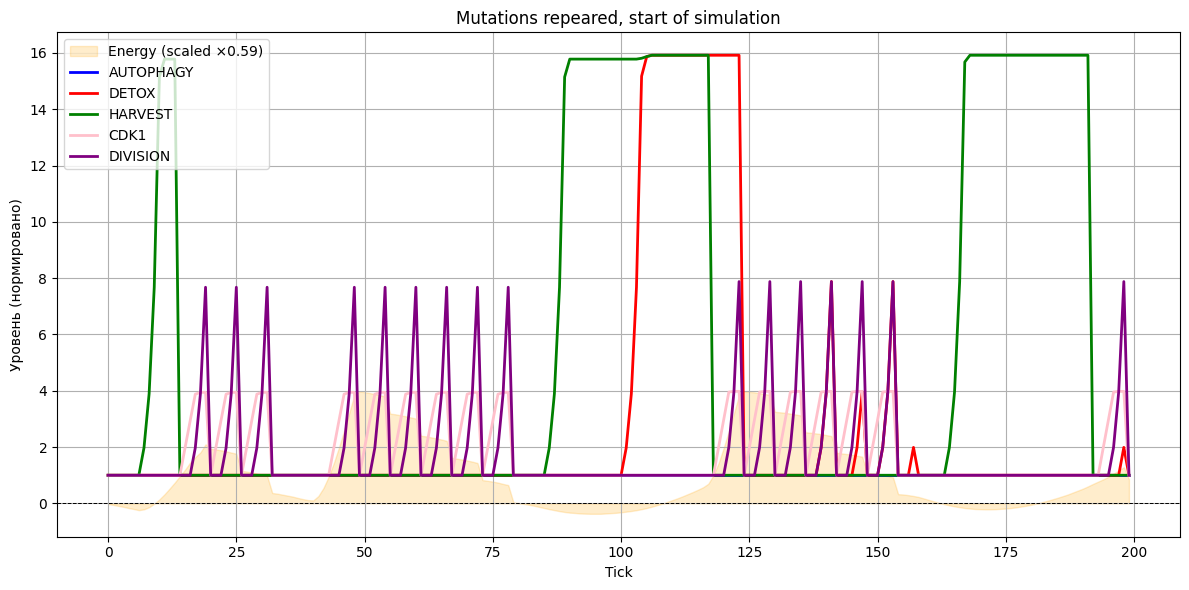

In [169]:
plot_gene_dynamics(df.iloc[:200, :], title="Mutations repeared, start of simulation",
                   genes={"AUTOPHAGY": "blue", 
                          "DETOX": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

In [66]:
# Тесты из прошлой модели

In [170]:
# Model with heavy mutagenesis
df, all_genes = run_simulation(
    ticks=3000,
    initial_food=1.0,
    initial_energy=0,
    initial_cell_num=1,
    support_cell_num=1000,
    energy_cost=0.002,
    mutation_chance=0.1,
    protein_stability=0.5,
    cellular_products={
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.0))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "MUTSENS":    (2, "qual", "st", "av", 50, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 1)),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 150, ["Energy <= 0", "FOODSENS == 'active'"], ["Energy >= 2", "Energy <= -2.9", "DIVISION == 'active'"], ("energy", 0.1)),
        "FEED":   (2,  "quan", "av", "av", 50, ["Energy <= -2"], ["Energy >= 2", "DIVISION == 'active'"], ("energy", 0.1)),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 50, ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (3,  "qual", "av", "wk", 50, ["Energy >= 1"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (12, "qual", "av", "av", 50, ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

Cell died at tick 288, energy=-3.01


,Food,Energotoxin,Energy,CellCount,mut_detected,tox_detected,ENGSENS,FOODSENS,MUTSENS,HARVEST,FEED,KINFEED,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-2,-0.03,1,False,False,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0
1,1.0,-2,-0.11,1,False,False,16.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0,1
2,1.0,-2,-0.19,1,False,False,16.0,1.0,4.0,1.0,1.0,2.0,1.0,16.0,1.0,2
3,1.0,-2,-0.28,1,True,False,16.0,1.0,4.0,1.0,1.0,4.0,1.0,16.0,1.0,3
4,1.0,-2,-0.38,1,True,False,16.0,2.0,4.0,1.0,1.0,4.0,1.0,16.0,1.0,4
5,1.0,-2,-0.47,1,True,False,16.0,4.0,4.0,1.0,1.0,4.0,1.0,16.0,1.0,5
6,1.0,-2,-0.58,1,True,False,16.0,8.0,4.0,2.0,1.0,4.0,1.0,16.0,1.0,6
7,1.0,-2,-0.71,1,True,False,16.0,16.0,4.0,4.0,1.0,8.0,1.0,16.0,1.0,7
8,1.0,-2,-0.53,1,True,False,16.0,16.0,4.0,8.0,1.0,4.0,1.0,16.0,1.0,8
9,1.0,-2,0.06,1,True,False,16.0,16.0,4.0,16.0,1.0,4.0,1.0,16.0,1.0,9


In [171]:
df.tail(5)

,Food,Energotoxin,Energy,CellCount,mut_detected,tox_detected,ENGSENS,FOODSENS,MUTSENS,HARVEST,FEED,KINFEED,CDK1,MUTGUARD,DIVISION,Tick
284,1.0,-2,-1.92,524288,False,False,4.0,4.0,4.0,1.0,1.0,4.0,8.0,16.0,4.0,284
285,1.0,-2,-2.06,524288,True,False,4.0,4.0,16.0,1.0,1.0,4.0,16.0,16.0,5.0,285
286,1.0,-2,-2.20,524288,True,False,4.0,4.0,16.0,1.0,2.0,4.0,16.0,16.0,6.0,286
287,1.0,-2,-2.34,524288,True,False,4.0,4.0,16.0,1.0,4.0,4.0,16.0,16.0,7.0,287
288,1.0,-2,-3.01,1048576,False,False,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,288


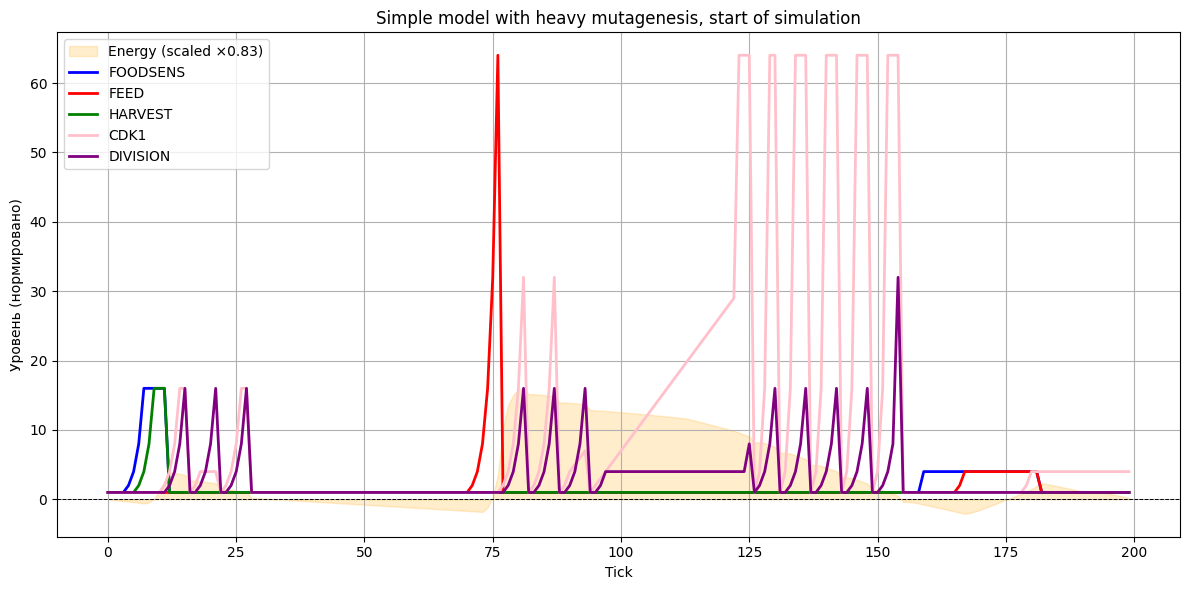

In [172]:
plot_gene_dynamics(df.iloc[:200, :], title="Simple model with heavy mutagenesis, start of simulation",
                   genes={"FOODSENS": "blue", 
                          "FEED": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

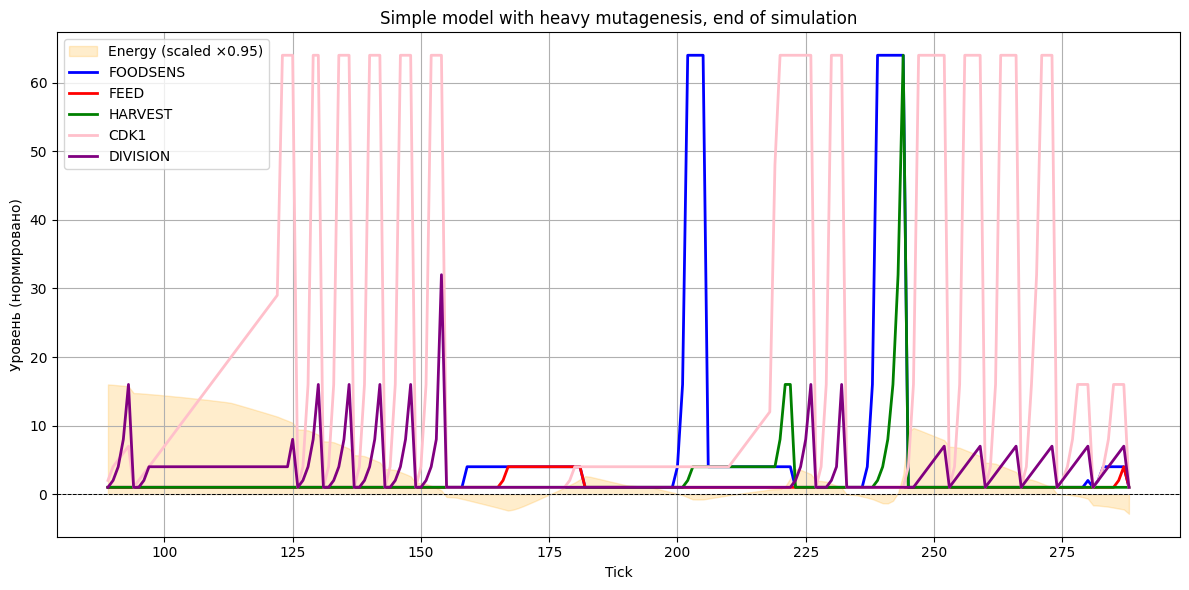

In [173]:
plot_gene_dynamics(df.iloc[-200:, :], title="Simple model with heavy mutagenesis, end of simulation",
                   genes={"FOODSENS": "blue", 
                          "FEED": "red", 
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

In [174]:
# Bigger model with toxins, waste and low mutagenesis, but with normal sensor of mutations
df, all_genes = run_simulation(
    ticks=3000,
    initial_food=1.0,
    initial_energy=0,
    initial_cell_num=1,
    support_cell_num=10,
    energy_cost=0.002,
    mutation_chance=0.0001,
    protein_stability=0.8,
    cellular_products={
        "Wastetoxin":  ("energy",  0.1),   # 0.1 * energy, spent for TPM
        "CytokineX":   ("TPMsum",  0.001),  # 0.05 * sum of cell's TPM
        "FooMol":      ("FOODSENS", 0.001),  # 0.2 * TPM of FOODSENS gene (only when FOODSENS active)
        "CellProduct": ("CELLPROD", 0.03)
    },
    toxins={
        "Energotoxin": (-2, ("energy", 0.2)), 
        "RNAtoxin":    (-2, ("TPM", 0.1)),
        "Wastetoxin":  (-3, ("common", 0.001)),
        "CytokineX":   (-3, ("energy",  0.0001)),
        "CellProduct": (-3, ("energy", 0.003))
    },
    receptors={
        "ENGSENS":   (12, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], False),
        "FOODSENS":  (4,  "qual", "av", "av", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "DIVISION == 'active'"], False),
        "TOXSENS":  (2,  "qual", "wk", "wk", 50, ["DIVISION == 'inactive'"], ["Toxin < -2.9", "DIVISION == 'active'"], ("toxsens", 0.01)),
        "TOXNONSENS":  (2,  "qual", "wk", "av", 50, ["Energy <= -1"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("toxsens", 0.1)),
        "MUTSENS":    (2, "qual", "st", "av", 50, ["ENGSENS == 'active'"], ["DIVISION == 'active'"], ("mutsens", 0.1)),
        "STRESSRESP": (5,  "qual", "wk", "av", 50, ["Energy <= -1", "DIVISION == 'inactive'"], ["Energy >= -1", "CDK1 == 'active'", "DIVISION == 'active'"], ("energy", 0.002)),
        "FUNAKTIV":   (4,  "qual", "av", "av", 50, ["Energy >= 0"], ["Energy < 0", "KINSTRESS == 'active'", "DIVISION == 'active'"], False),
    },
    metabolism={
        "HARVEST":   (2,  "quan", "av", "av", 50, ["Energy <= 0", "FOODSENS == 'active'"], ["Energy >= 1", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.01)),
        "FEED":    (2,  "quan", "st", "st", 50, ["Energy <= 1", "KINFEED == 'active'"], ["Energy >= 2", "Energy <= -2.99", "DIVISION == 'active'"], ("energy", 0.005)),
        "AUTOPHAGY":  (2,  "quan", "av", "av", 50, ["STRESSRESP == 'active'"], ["Energy >= -1", "DIVISION == 'active'"], ("process", 0.0005)),
        "PROTREP":    (4,  "quan", "st", "av", 50, ["AUTOPHAGY == 'active'", "Energy <= -1.5"], ["Energy >= 1", "DIVISION == 'active'"], ("process", 0.001)),
        "DETOX":   (2,  "quan", "av", "av", 40, ["Toxin_detected == True"], ["DETOXX == 'active'", "DIVISION == 'active'"], ("detox", 0.01)),
        "DETOXX":   (2,  "quan", "st", "st", 10, ["Toxin_detected == True", "Toxin >= -1"], ["Toxin <= -2", "CDK1 == 'active'", "DIVISION == 'active'"], ("detox", 1)),
        "CELLPROD": (2,  "quan", "st", "st", 50, ["KINFUNK == 'active'"], ["Toxin > 1.5", "STRESSRESP == 'active'", "Energy <= -0.5", "DIVISION == 'active'"], ("energy", 0.005)),
    },
    kinases={
        "KINFEED":     (3, "qual", "av", "wk", 50, ["Energy <= 1", "ENGSENS == 'active'"], ["Energy > 0.5", "DIVISION == 'active'"], False),
        "KINTOX":    (3, "qual", "av", "wk", 50, ["Toxin_detected == True"], ["Toxin_detected == False", "DIVISION == 'active'"], False),
        "KINSTRESS": (3, "qual", "av", "wk", 50, ["STRESSRESP == 'active'"], ["Energy > 0", "DIVISION == 'active'"], False),
        "KINFUNK": (3, "qual", "av", "wk", 50, ["FUNAKTIV == 'active'"], ["KINFUNK == 'active'", "STRESSRESP == 'active'", "DIVISION == 'active'"], False),
    },
    cell_cycle={
        "CDK1":      (2,  "qual", "wk", "wk", 50, ["Energy >= 1.25"], ["DIVISION == 'active'"], False),
    },
    division={
        "MUTGUARD":  (2, "qual", "st", "av", 50, ["DIVISION == 'inactive'"], ["DIVISION == 'active'"], ("mutrep", 0.01)),
        "DIVISION":  (6, "qual", "av", "av", 50, ["CDK1 == 'active'"], ["DIVISION == 'active'"], ("div", 1)),
    }
)
df.head(15)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
0,1.0,-3.000,-2.998,-3.000,-3.0,-2.0,-2.0,-0.08,1,False,...,1.0,1.0,1.000000,1.0,1.0,1.00000,1.000000,3.945667,1.0,0
1,1.0,-2.999,-2.995,-3.000,-3.0,-2.0,-2.0,-0.21,1,False,...,1.0,1.0,1.000000,1.0,1.0,1.00000,1.000000,15.568285,1.0,1
2,1.0,-2.998,-2.990,-3.000,-3.0,-2.0,-2.0,-0.36,1,False,...,1.0,1.0,1.972833,1.0,1.0,1.00000,1.000000,15.782665,1.0,2
3,1.0,-2.997,-2.984,-3.000,-3.0,-2.0,-2.0,-0.53,1,False,...,1.0,1.0,3.892070,1.0,1.0,1.00000,1.000000,15.782664,1.0,3
4,1.0,-2.995,-2.977,-3.000,-3.0,-2.0,-2.0,-0.70,1,False,...,1.0,1.0,3.945666,1.0,1.0,1.00000,1.000000,15.782663,1.0,4
5,1.0,-2.994,-2.970,-3.000,-3.0,-2.0,-2.0,-0.89,1,False,...,1.0,1.0,3.945666,1.0,1.0,1.00000,1.000000,15.782662,1.0,5
6,1.0,-2.992,-2.961,-3.000,-3.0,-2.0,-2.0,-1.11,1,False,...,1.0,1.0,3.945665,1.0,1.0,1.00000,1.000000,15.782661,1.0,6
7,1.0,-2.989,-2.947,-2.999,-3.0,-2.0,-2.0,-1.07,1,False,...,1.0,1.0,3.945665,1.0,1.0,1.00000,1.000000,15.782658,1.0,7
8,1.0,-2.986,-2.932,-2.998,-3.0,-2.0,-2.0,-0.82,1,False,...,1.0,1.0,3.945664,1.0,1.0,1.00000,1.000000,15.782656,1.0,8
9,1.0,-2.983,-2.916,-2.996,-3.0,-2.0,-2.0,-0.35,1,False,...,1.0,1.0,3.945663,1.0,1.0,1.00000,1.000000,15.782654,1.0,9


In [175]:
df.tail(5)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
2995,1.0,1.586207e+77,7.931035e+77,1.972726e+77,-3.0,-3.0,-3.0,4.11,2964277484475294602843417216222410441043711607...,False,...,1.0,1.0,1.0,3.899743,1.0,3.801999,3.899743,15.598972,7.413409,2995
2996,1.0,6.149331e+76,3.074665e+77,1.972726e+77,-3.0,-3.0,-3.0,3.03,5928554968950589205686834432444820882087423214...,False,...,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,2996
2997,1.0,2.489993e+76,1.244997e+77,1.972726e+77,-3.0,-3.0,-3.0,2.94,5928554968950589205686834432444820882087423214...,False,...,1.0,1.0,1.0,1.000000,1.0,1.000000,1.949872,3.899743,1.000000,2997
2998,1.0,6.005520e+76,3.002760e+77,1.972726e+77,-3.0,-3.0,-3.0,2.80,5928554968950589205686834432444820882087423214...,False,...,1.0,1.0,1.0,1.000000,1.0,1.000000,2.875935,15.207996,1.000000,2998
2999,1.0,1.264193e+77,6.320964e+77,1.972726e+77,-3.0,-3.0,-3.0,2.63,5928554968950589205686834432444820882087423214...,False,...,1.0,1.0,1.0,1.949872,1.0,1.000000,3.778788,15.598972,1.949872,2999


In [176]:
df.mut_detected.value_counts()

mut_detected
False    2957
True       43
Name: count, dtype: int64

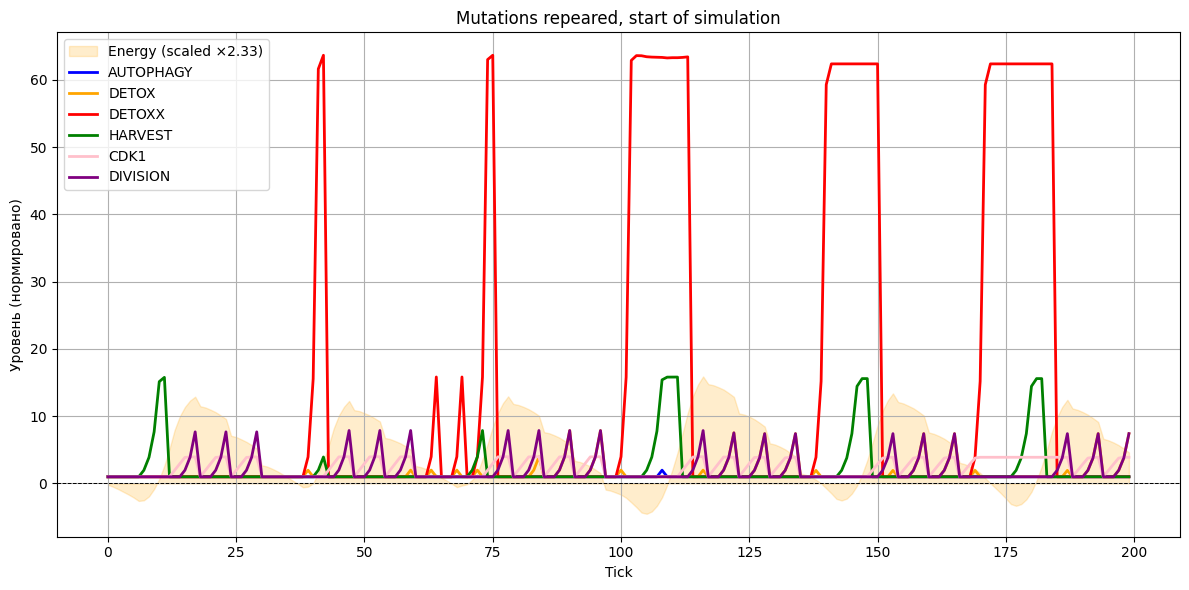

In [177]:
plot_gene_dynamics(df.iloc[:200, :], title="Mutations repeared, start of simulation",
                   genes={"AUTOPHAGY": "blue", 
                          "DETOX": "orange",
                          "DETOXX": "red",
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

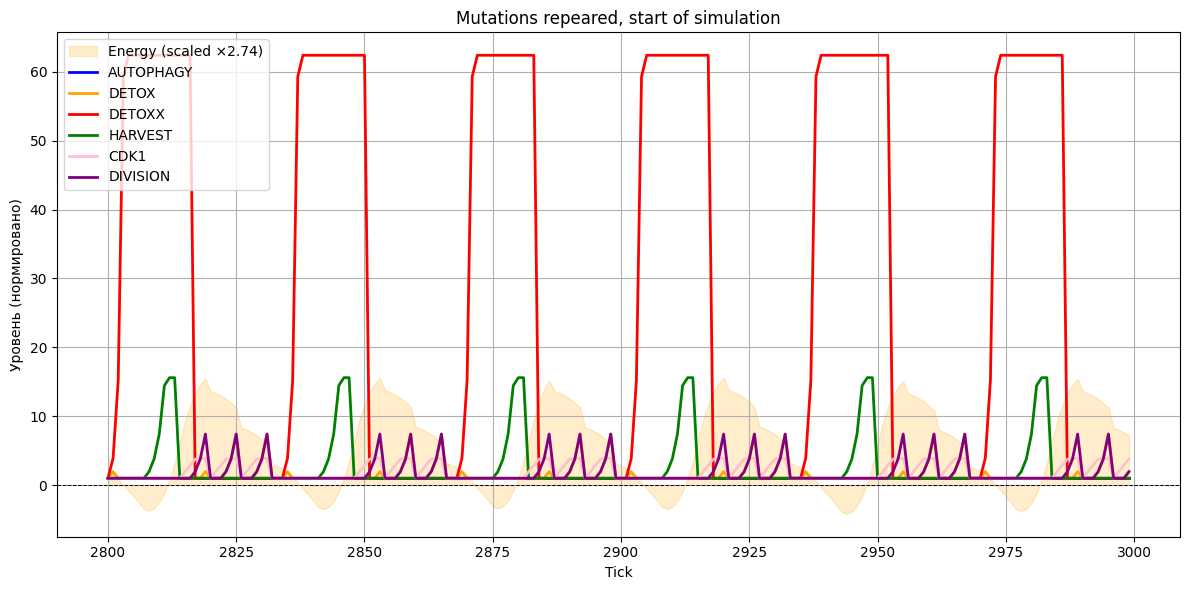

In [178]:
plot_gene_dynamics(df.iloc[-200:, :], title="Mutations repeared, start of simulation",
                   genes={"AUTOPHAGY": "blue", 
                          "DETOX": "orange",
                          "DETOXX": "red",
                          "HARVEST": "green",
                          "CDK1": "pink",
                          "DIVISION": "purple"})

In [179]:
df.tail(35)

,Food,Wastetoxin,CytokineX,FooMol,CellProduct,Energotoxin,RNAtoxin,Energy,CellCount,mut_detected,...,DETOXX,CELLPROD,KINFEED,KINTOX,KINSTRESS,KINFUNK,CDK1,MUTGUARD,DIVISION,Tick
2965,1.0,1.580241e+76,7.901205e+76,2.465907e+76,-3.0,-3.0,-3.0,2.50,7410693711188236507108543040556026102609279018...,False,...,1.000000,1.0,1.000000,1.949872,1.0,1.000000,3.778788,15.598972,1.949872,2965
2966,1.0,2.586884e+76,1.293442e+77,2.465907e+76,-3.0,-3.0,-3.0,2.28,7410693711188236507108543040556026102609279018...,False,...,1.000000,1.0,1.000000,3.801999,1.0,1.949872,3.899743,15.598972,3.801999,2966
2967,1.0,3.965518e+76,1.982759e+77,2.465907e+76,-3.0,-3.0,-3.0,2.04,7410693711188236507108543040556026102609279018...,False,...,1.000000,1.0,1.000000,3.899743,1.0,3.801999,3.899743,15.598972,7.413409,2967
2968,1.0,1.537333e+76,7.686663e+76,2.465907e+76,-3.0,-3.0,-3.0,0.97,1482138742237647301421708608111205220521855803...,False,...,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,2968
2969,1.0,6.224983e+75,3.112491e+76,2.465907e+76,-3.0,-3.0,-3.0,0.88,1482138742237647301421708608111205220521855803...,False,...,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,3.899743,1.000000,2969
2970,1.0,1.473223e+76,7.366115e+76,2.465907e+76,-3.0,-3.0,-3.0,0.74,1482138742237647301421708608111205220521855803...,False,...,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,15.207996,1.000000,2970
2971,1.0,3.076717e+76,1.538359e+77,2.465907e+76,-3.0,-3.0,-3.0,0.57,1482138742237647301421708608111205220521855803...,False,...,3.899743,1.0,1.000000,1.949872,1.0,1.000000,1.000000,15.598972,1.000000,2971
2972,1.0,5.065432e+76,2.532716e+77,2.465907e+76,-3.0,-3.0,-3.0,0.34,1482138742237647301421708608111205220521855803...,False,...,15.207996,1.0,1.000000,3.801999,1.0,1.949872,1.000000,15.598972,1.000000,2972
2973,1.0,2.926357e+76,1.463178e+77,2.465907e+76,-3.0,-3.0,-3.0,0.02,1482138742237647301421708608111205220521855803...,False,...,59.307275,1.0,1.949872,3.899743,1.0,3.801999,1.000000,15.598972,1.000000,2973
2974,1.0,4.365033e+76,2.182516e+77,2.465907e+76,-3.0,-3.0,-3.0,-0.28,1482138742237647301421708608111205220521855803...,False,...,62.395888,1.0,3.801999,3.899743,1.0,1.000000,1.000000,15.598972,1.000000,2974


In [139]:
# Осталась проблема - накопление эффекта от токсичных клеточных продуктов наступает слишком быстро при делении клеток.
# Обезвреживание никак не получается
# Впервые не могу решить проблему баланса
# Попытка решить - строка:
# detox_power   = (eff_prot * state["cell_count"] / 64) * val * support_ratio
# Либо клиповать пожёсче, либо пересмотреть логику ёмкости среды
# Либо побыстрее ввести логику шаперонов

In [ ]:
# Функция в предшествующем блоке очень нравится. Она работает
# Токсины и продукты выделяются
# Токсины травят, но их эффект пришлось обрезать
# Детекцию токсинов также пришлось обрезать, поскольку слишком большие сигма приводят к бесконеным эффектам
# Детекция мутагенеза, сам мутагенез и репарация работают
# Функции белков отвязаны от единиц экспрессии генов, и привязаны к единицам собственно белков
# Белки могут разваливаться
# ХОТЬ СЕЙЧАС В ПРОДАКШ!
#
# Осталось реализовать
# Фосфорилирование
# Гибель клеток как функцию вероятности
# Гибель при избытке энергии
# Выработку пищи в среде, +1 за каждый такт
# Потребление энергии клетки, которое рассчитывается как 1 для количества всех генов * на 16
# Эффективность переработки Food среды в энергию. Растёт при большем значении Food, падает при меньшем.
# Метилирование, при 0 - активность экспрессии *2, при 1 - активность экспресии *0.
# Ген деметилируется, скажем, на 0.2 при попытке начать экспресию, а при делении - метилируется на 0.25.
# Шапероны малого размера, которые таргетируют белки по их именам, и предохраняют их от развала, придавая им преиущества стабильности
# Лёгкий мутагенез, связанный с изменением величины эффекта
# Тяжёлый мутагенез, связанный с хромосомными перестройками и химерными генами